/Users/zinaghottis/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Epoch 1/50
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 117s 15ms/step - loss: 0.0042 - mae: 0.0380 - val_loss: 0.0012 - val_mae: 0.0252
Epoch 2/50
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 120s 15ms/step - loss: 8.2944e-04 - mae: 0.0197 - val_loss: 0.0023 - val_mae: 0.0405
Epoch 3/50
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 117s 15ms/step - loss: 6.9324e-04 - mae: 0.0178 - val_loss: 0.0018 - val_mae: 0.0341
Epoch 4/50
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 119s 15ms/step - loss: 6.1548e-04 - mae: 0.0167 - val_loss: 0.0016 - val_mae: 0.0309
Epoch 5/50
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 112s 14ms/step - loss: 5.6687e-04 - mae: 0.0161 - val_loss: 0.0021 - val_mae: 0.0368
Epoch 6/50
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 118s 15ms/step - loss: 5.4077e-04 - mae: 0.0156 - val_loss: 0.0016 - val_mae: 0.0323
Epoch 7/50
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 112s 14ms/step - loss: 5.4159e-04 - mae: 0.0156 - val_loss: 0.0019 - val_mae: 0.0332
Epoch 8/50
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 118s 15ms/step - loss: 5.2121e-04 - mae: 0.0153 - val_loss: 0.0015 - val_

7735/7735 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step
1934/1934 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step
Train Features Shape: (247496, 1)
Test Features Shape: (61875, 1)
MAE: 0.008501542037686313
RMSE: 0.023842705503515593
R² Score: 0.9815855054992031


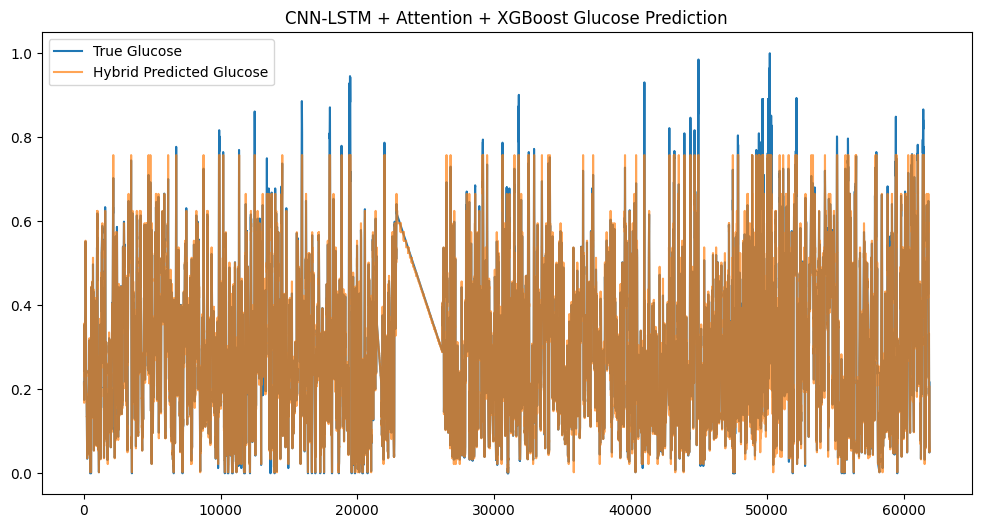

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout, BatchNormalization, Flatten, Attention
import xgboost as xgb
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Path to dataset
dataset_path = "/Users/zinaghottis/Downloads/HUPA-UCM Diabetes Dataset/Preprocessed"

# 1. Load and Merge Data

def load_and_merge_data(directory):
    all_data = []
    for file in os.listdir(directory):
        if file.endswith(".csv"):
            file_path = os.path.join(directory, file)
            data = pd.read_csv(file_path, delimiter=';')
            data['time'] = pd.to_datetime(data['time'], errors='coerce')
            all_data.append(data)
    return pd.concat(all_data, ignore_index=True)

# Load the dataset
data = load_and_merge_data(dataset_path)

# 2. Feature Engineering

data['glucose_rate_of_change'] = data['glucose'].diff() / (data['time'].diff().dt.total_seconds() / 60)

data['insulin_carb_ratio'] = data['bolus_volume_delivered'] / (data['carb_input'] + 1e-6)

data['activity_intensity'] = data['heart_rate'] * data['steps']

data.dropna(inplace=True)

# 3. Normalize Features

scaler = MinMaxScaler()
feature_columns = ['glucose', 'glucose_rate_of_change', 'insulin_carb_ratio', 'activity_intensity', 'calories', 'basal_rate']
data[feature_columns] = scaler.fit_transform(data[feature_columns])

# 4. Prepare Sequences for CNN-LSTM

def create_sequences(data, target_column, seq_length=20):
    X, y = [], []
    data = data.reset_index(drop=True)
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length][feature_columns].values)
        y.append(data.iloc[i+seq_length][target_column])
    return np.array(X), np.array(y)

X, y = create_sequences(data, target_column='glucose')

# 5. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Ensure the shapes of y_train and y_test are correct
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

# 6. Define CNN-LSTM Model with Attention for Feature Extraction
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
cnn = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
cnn = BatchNormalization()(cnn)
cnn = Dropout(0.3)(cnn)
lstm = LSTM(128, return_sequences=True)(cnn)
attention = Attention()([lstm, lstm])  
flatten = Flatten()(attention)
dense = Dense(64, activation='relu')(flatten)
dense = Dropout(0.3)(dense)


output = Dense(1, activation='linear')(dense)

feature_extractor = Model(inputs, output)
feature_extractor.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train CNN-LSTM with Attention
feature_extractor.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,  
    batch_size=32,
    verbose=1
)


# Save the CNN-LSTM model with Attention
feature_extractor.save('cnn_lstm_attention_feature_extractor.h5')

# Extract features from CNN-LSTM with Attention
train_features = feature_extractor.predict(X_train)
test_features = feature_extractor.predict(X_test)

# Verify the feature shapes
print("Train Features Shape:", train_features.shape)
print("Test Features Shape:", test_features.shape)

# 7. Train XGBoost Model

xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(train_features, y_train)

# Save the XGBoost model
xgb_model.save_model('xgboost_model_attention.json')

# 8. Evaluate Hybrid Model
y_pred = xgb_model.predict(test_features)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")

# 9. Visualize Results
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True Glucose')
plt.plot(y_pred, label='Hybrid Predicted Glucose', alpha=0.7)
plt.legend()
plt.title('CNN-LSTM + Attention + XGBoost Glucose Prediction')
plt.show()

# Save predictions
hybrid_predictions = pd.DataFrame({'True Glucose': y_test, 'Hybrid Predicted Glucose': y_pred})
hybrid_predictions.to_csv('hybrid_glucose_predictions_attention.csv', index=False)


Epoch 1/20
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 177s 23ms/step - loss: 0.0321 - mae: 0.0964 - val_loss: 0.0023 - val_mae: 0.0361
Epoch 2/20
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 183s 24ms/step - loss: 0.0020 - mae: 0.0305 - val_loss: 0.0025 - val_mae: 0.0398
Epoch 3/20
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 195s 25ms/step - loss: 0.0037 - mae: 0.0369 - val_loss: 7.1728e-04 - val_mae: 0.0150
Epoch 4/20
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 249s 32ms/step - loss: 0.0048 - mae: 0.0341 - val_loss: 6.1359e-04 - val_mae: 0.0126
Epoch 5/20
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 195s 25ms/step - loss: 0.0024 - mae: 0.0278 - val_loss: 0.0037 - val_mae: 0.0499
Epoch 6/20
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 182s 24ms/step - loss: 0.0021 - mae: 0.0242 - val_loss: 0.0372 - val_mae: 0.1552
Epoch 7/20
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 189s 24ms/step - loss: 0.0033 - mae: 0.0331 - val_loss: 0.0016 - val_mae: 0.0277
Epoch 8/20
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 188s 24ms/step - loss: 0.0029 - mae: 0.0325 - val_loss: 5.2836e-04 - val_mae: 0.0119
Epoc

7735/7735 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step
1934/1934 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step
Mean Absolute Error: 0.012071575687024279
Mean Squared Error: 0.0006554412211705233
R2 Score: 0.9787684117439214


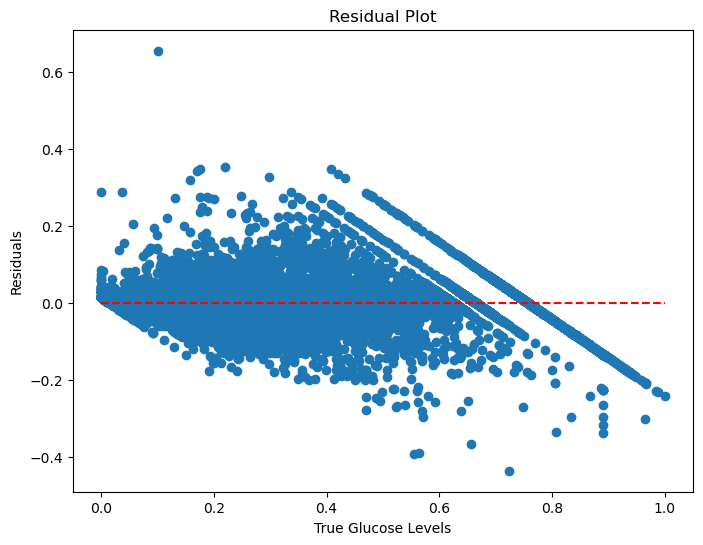

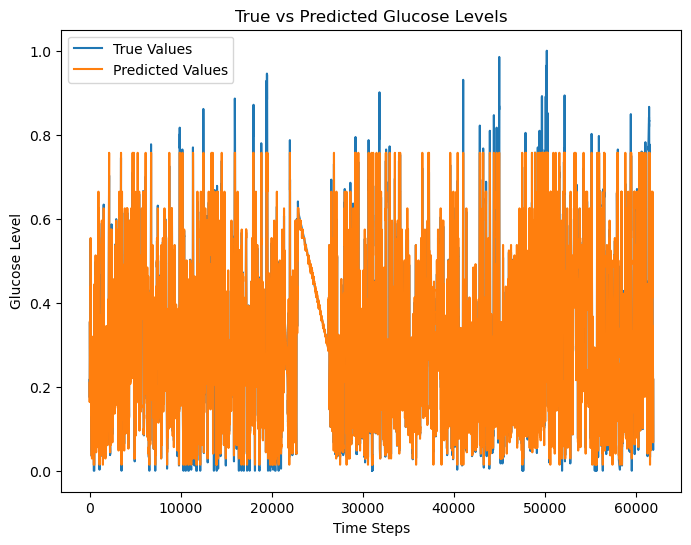

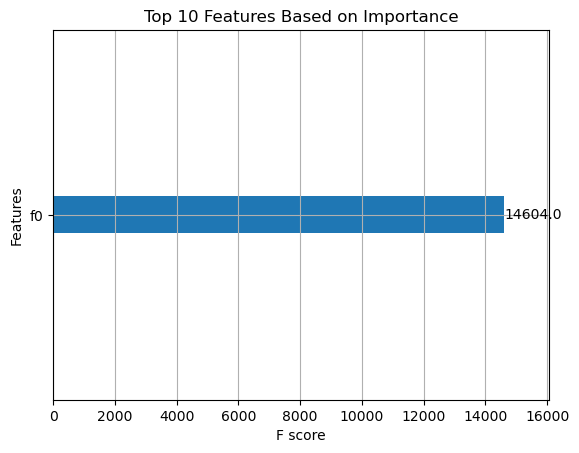

In [16]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout, BatchNormalization, Flatten, Attention
import xgboost as xgb
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Path to dataset
dataset_path = "/Users/zinaghottis/Downloads/HUPA-UCM Diabetes Dataset/Preprocessed"

# 1. Load and Merge Data
def load_and_merge_data(directory):
    all_data = []
    for file in os.listdir(directory):
        if file.endswith(".csv"):
            file_path = os.path.join(directory, file)
            data = pd.read_csv(file_path, delimiter=';')
            data['time'] = pd.to_datetime(data['time'], errors='coerce')
            all_data.append(data)
    return pd.concat(all_data, ignore_index=True)

# Load the dataset
data = load_and_merge_data(dataset_path)

# 2. Fix 'carb_input,Patient ID' column
data[['carb_input', 'Patient ID']] = data['carb_input,Patient ID'].str.split(',', expand=True)

# Convert 'carb_input' to numeric if it's not already
data['carb_input'] = pd.to_numeric(data['carb_input'], errors='coerce')

# Drop the original column
data.drop(columns=['carb_input,Patient ID'], inplace=True)

# 3. Feature Engineering
data['glucose_rate_of_change'] = data['glucose'].diff() / (data['time'].diff().dt.total_seconds() / 60)
data['insulin_carb_ratio'] = data['bolus_volume_delivered'] / (data['carb_input'] + 1e-6)
data['activity_intensity'] = data['heart_rate'] * data['steps']
data.dropna(inplace=True)

# Solution: Repeat patient IDs to match the number of rows in the dataset
patient_ids = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p9', 'p10', 'p11', 
               'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 
               'p23', 'p24', 'p25', 'p26', 'p27', 'p28']

# Repeat the patient IDs list enough times to cover all rows in the dataset
repeated_patient_ids = np.tile(patient_ids, int(np.ceil(len(data) / len(patient_ids))))

# Trim or slice to ensure it matches the exact length of the dataset
repeated_patient_ids = repeated_patient_ids[:len(data)]

# Assign to the DataFrame
data['Patient ID'] = repeated_patient_ids

# 4. Normalize Features
scaler = MinMaxScaler()
feature_columns = ['glucose', 'glucose_rate_of_change', 'insulin_carb_ratio', 'activity_intensity', 'calories', 'basal_rate']
data[feature_columns] = scaler.fit_transform(data[feature_columns])

# 5. Prepare Sequences for CNN-LSTM
def create_sequences(data, target_column, seq_length=20):
    X, y = [], []
    data = data.reset_index(drop=True)
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length][feature_columns].values)
        y.append(data.iloc[i+seq_length][target_column])
    return np.array(X), np.array(y)

X, y = create_sequences(data, target_column='glucose')

# 6. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

# 7. Define CNN-LSTM Model with Attention for Feature Extraction
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
cnn = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
cnn = BatchNormalization()(cnn)
cnn = Dropout(0.3)(cnn)
lstm = LSTM(128, return_sequences=True)(cnn)
attention = Attention()([lstm, lstm])  
flatten = Flatten()(attention)
dense = Dense(64, activation='relu')(flatten)
dense = Dropout(0.3)(dense)
output = Dense(1, activation='linear')(dense)

feature_extractor = Model(inputs, output)
feature_extractor.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train CNN-LSTM with Attention
feature_extractor.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,  
    batch_size=32,
    verbose=1
)

# Save the CNN-LSTM model with Attention
feature_extractor.save('cnn_lstm_attention_feature_extractor.h5')

# Extract features from CNN-LSTM with Attention
train_features = feature_extractor.predict(X_train)
test_features = feature_extractor.predict(X_test)

# 8. Train XGBoost Model
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(train_features, y_train)

# Save the XGBoost model
xgb_model.save_model('xgboost_model_attention.json')

# 9. Evaluate Hybrid Model
y_pred = xgb_model.predict(test_features)

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")


# Residual plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred - y_test)
plt.hlines(y=0, xmin=min(y_test), xmax=max(y_test), colors='r', linestyles='--')
plt.xlabel('True Glucose Levels')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Visualize prediction vs true values
plt.figure(figsize=(8, 6))
plt.plot(y_test, label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.legend()
plt.xlabel('Time Steps')
plt.ylabel('Glucose Level')
plt.title('True vs Predicted Glucose Levels')
plt.show()

# Feature importance (using XGBoost)
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10)
plt.title('Top 10 Features Based on Importance')
plt.show()


In [26]:
# Train CNN-LSTM with Attention
history = feature_extractor.fit(
    X_train, y_train, 
    epochs=20, 
    batch_size=64, 
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/20
3868/3868 ━━━━━━━━━━━━━━━━━━━━ 83s 21ms/step - loss: 0.0031 - mae: 0.0369 - val_loss: 0.0014 - val_mae: 0.0243
Epoch 2/20
3868/3868 ━━━━━━━━━━━━━━━━━━━━ 85s 22ms/step - loss: 0.0018 - mae: 0.0272 - val_loss: 0.0017 - val_mae: 0.0314
Epoch 3/20
3868/3868 ━━━━━━━━━━━━━━━━━━━━ 82s 21ms/step - loss: 0.0027 - mae: 0.0358 - val_loss: 0.0041 - val_mae: 0.0491
Epoch 4/20
3868/3868 ━━━━━━━━━━━━━━━━━━━━ 82s 21ms/step - loss: 0.0021 - mae: 0.0322 - val_loss: 8.8496e-04 - val_mae: 0.0194
Epoch 5/20
3868/3868 ━━━━━━━━━━━━━━━━━━━━ 99s 25ms/step - loss: 0.0025 - mae: 0.0340 - val_loss: 0.0034 - val_mae: 0.0456
Epoch 6/20
3868/3868 ━━━━━━━━━━━━━━━━━━━━ 81s 21ms/step - loss: 0.0025 - mae: 0.0343 - val_loss: 0.0040 - val_mae: 0.0500
Epoch 7/20
3868/3868 ━━━━━━━━━━━━━━━━━━━━ 96s 25ms/step - loss: 0.0034 - mae: 0.0348 - val_loss: 0.0205 - val_mae: 0.1072
Epoch 8/20
3868/3868 ━━━━━━━━━━━━━━━━━━━━ 106s 27ms/step - loss: 0.0022 - mae: 0.0323 - val_loss: 0.0053 - val_mae: 0.0644
Epoch 9/20
3868/386

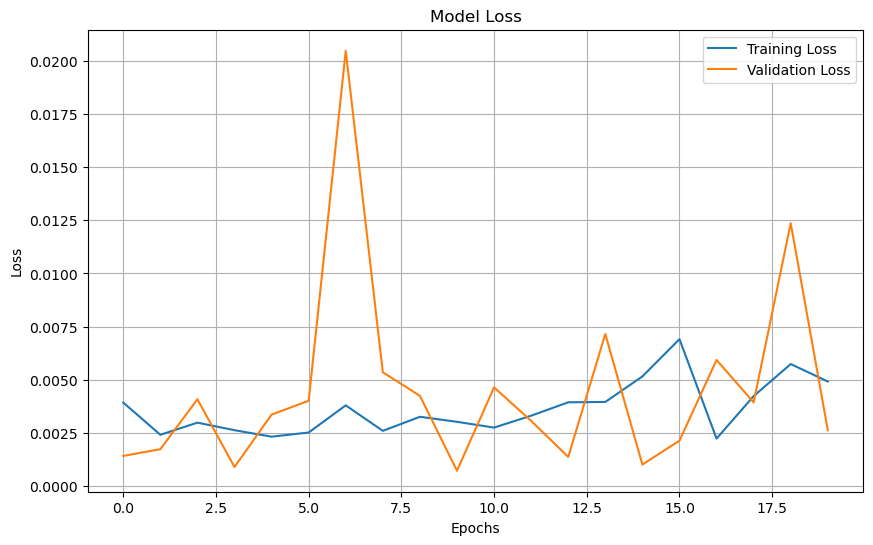

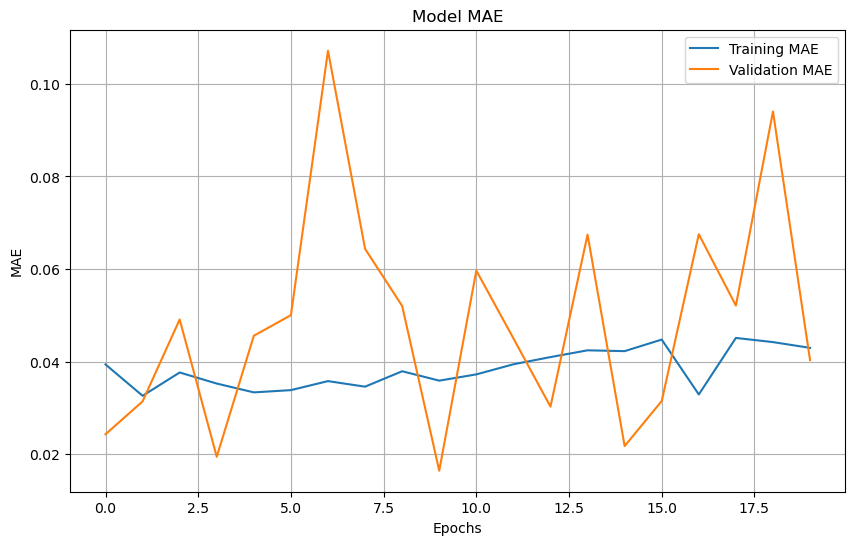

In [27]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training & validation MAE (Mean Absolute Error) values
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()


In [28]:
# Make predictions
y_pred = feature_extractor.predict(X_test, verbose=0)

# Evaluate the model's performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R2 Score: {r2}")


Mean Absolute Error (MAE): 0.016443303326452347
Mean Squared Error (MSE): 0.0007112435000691495
R2 Score: 0.9769608186736981


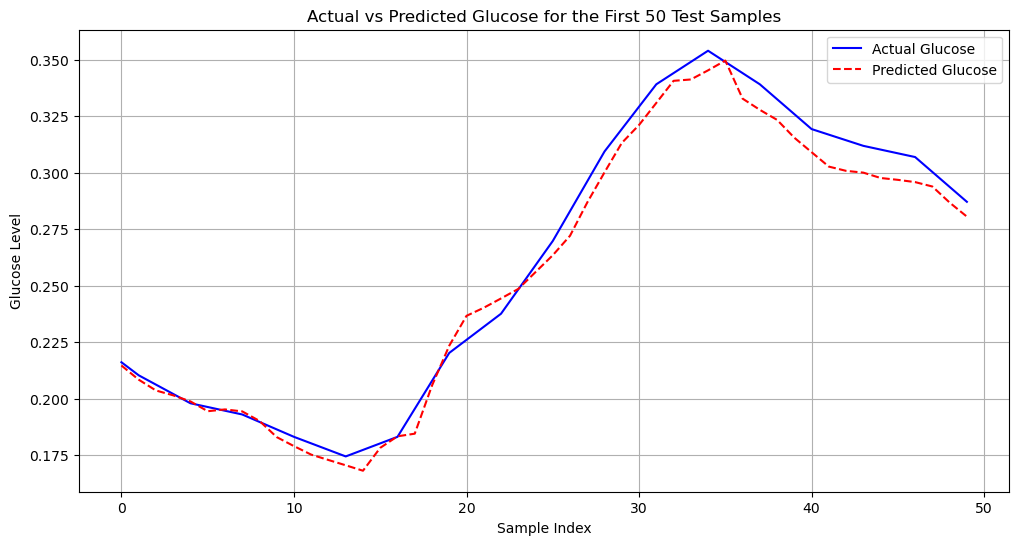

In [29]:
# Plot Actual vs Predicted Glucose Levels for the first few test samples
plt.figure(figsize=(12, 6))
plt.plot(y_test[:50], label='Actual Glucose', color='blue')
plt.plot(y_pred[:50], label='Predicted Glucose', color='red', linestyle='--')
plt.title('Actual vs Predicted Glucose for the First 50 Test Samples')
plt.xlabel('Sample Index')
plt.ylabel('Glucose Level')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/20
3868/3868 ━━━━━━━━━━━━━━━━━━━━ 154s 38ms/step - loss: 0.0402 - mae: 0.1116 - val_loss: 5.9377e-04 - val_mae: 0.0157
Epoch 2/20
3868/3868 ━━━━━━━━━━━━━━━━━━━━ 155s 40ms/step - loss: 8.0954e-04 - mae: 0.0210 - val_loss: 7.5088e-04 - val_mae: 0.0185
Epoch 3/20
3868/3868 ━━━━━━━━━━━━━━━━━━━━ 189s 49ms/step - loss: 0.0011 - mae: 0.0241 - val_loss: 5.0754e-04 - val_mae: 0.0116
Epoch 4/20
3868/3868 ━━━━━━━━━━━━━━━━━━━━ 146s 38ms/step - loss: 0.0017 - mae: 0.0296 - val_loss: 0.0013 - val_mae: 0.0256
Epoch 5/20
3868/3868 ━━━━━━━━━━━━━━━━━━━━ 128s 33ms/step - loss: 0.0014 - mae: 0.0251 - val_loss: 0.0011 - val_mae: 0.0198
Epoch 6/20
3868/3868 ━━━━━━━━━━━━━━━━━━━━ 107s 28ms/step - loss: 0.0016 - mae: 0.0256 - val_loss: 0.0137 - val_mae: 0.0898
Epoch 7/20
3868/3868 ━━━━━━━━━━━━━━━━━━━━ 95s 25ms/step - loss: 0.0016 - mae: 0.0261 - val_loss: 7.3228e-04 - val_mae: 0.0172
Epoch 8/20
3868/3868 ━━━━━━━━━━━━━━━━━━━━ 78s 20ms/step - loss: 8.9697e-04 - mae: 0.0208 - val_loss: 9.5803e-04 - val_ma

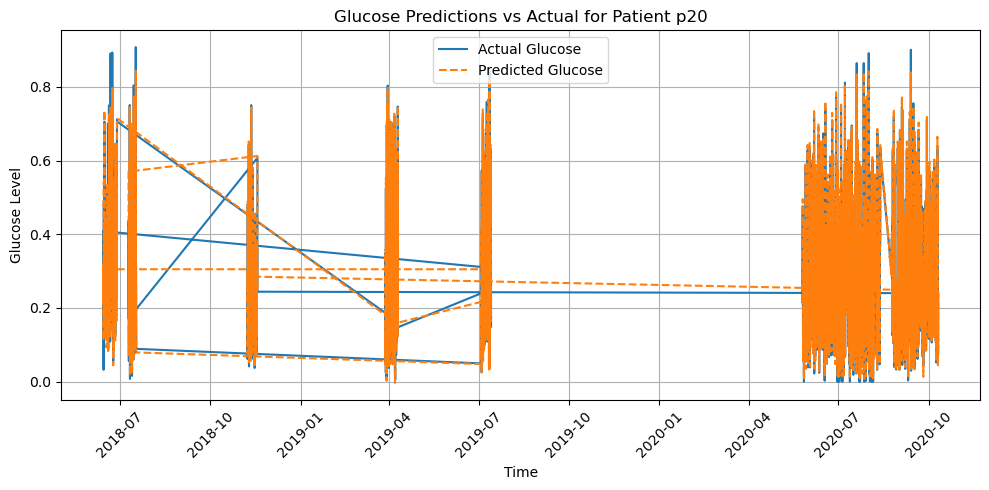

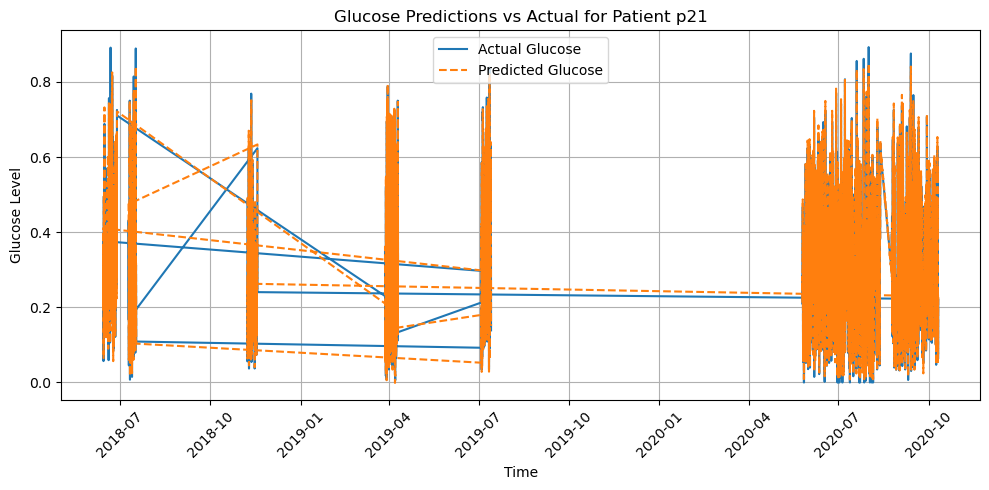

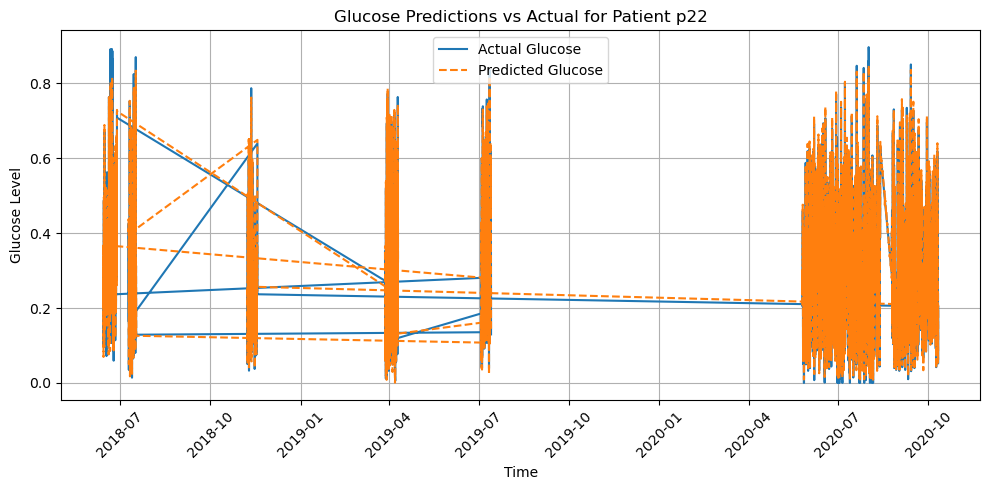

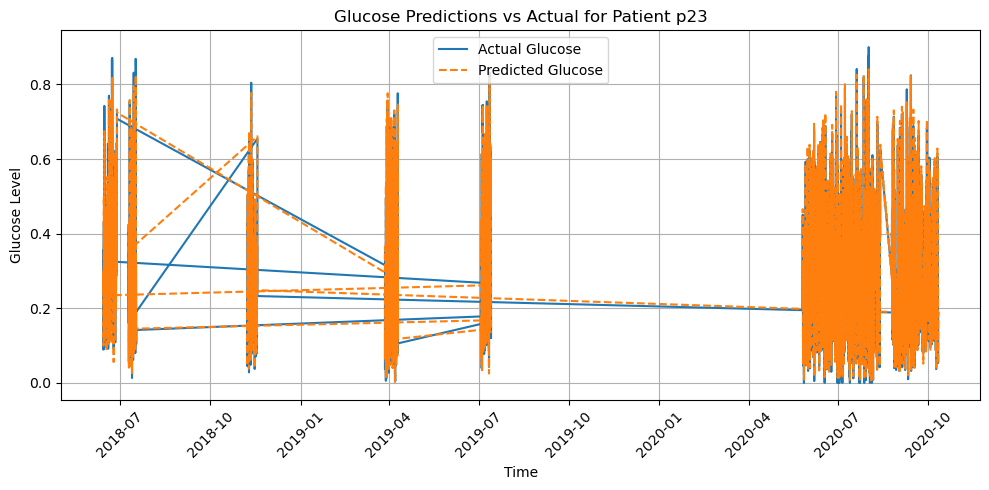

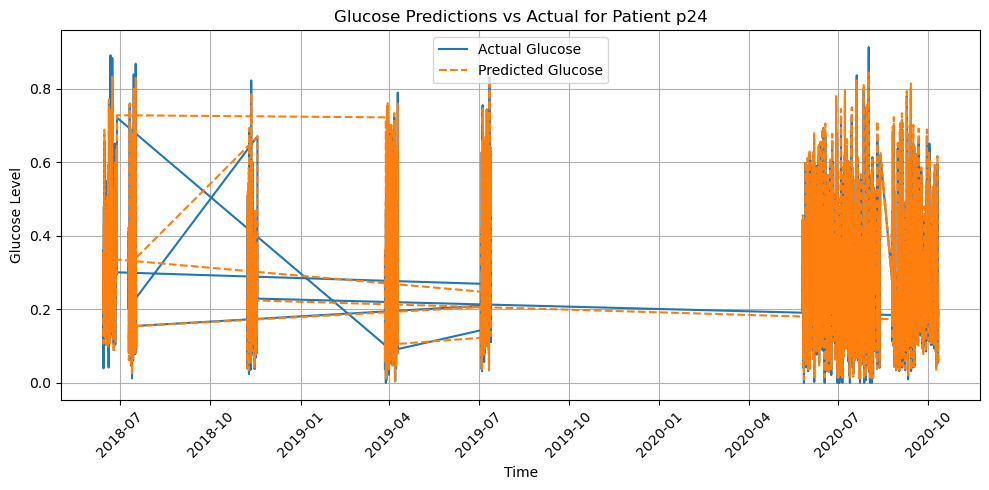

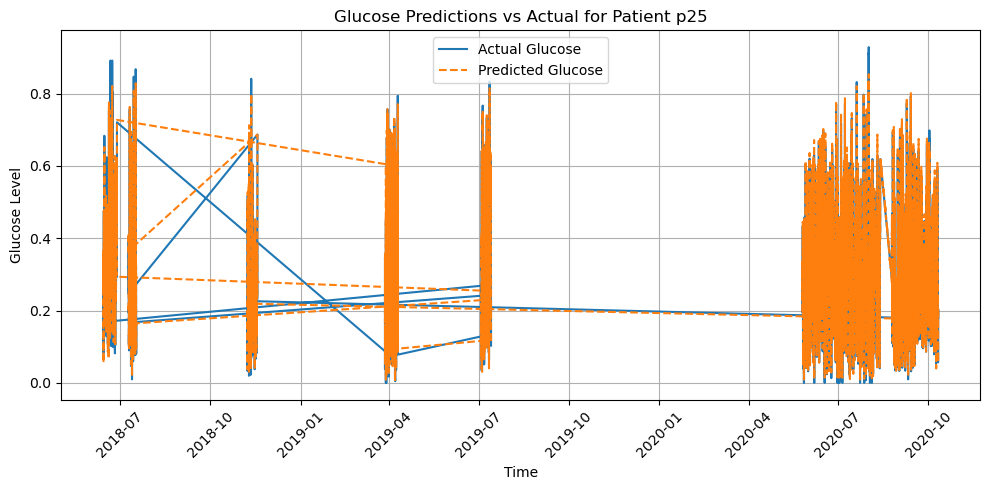

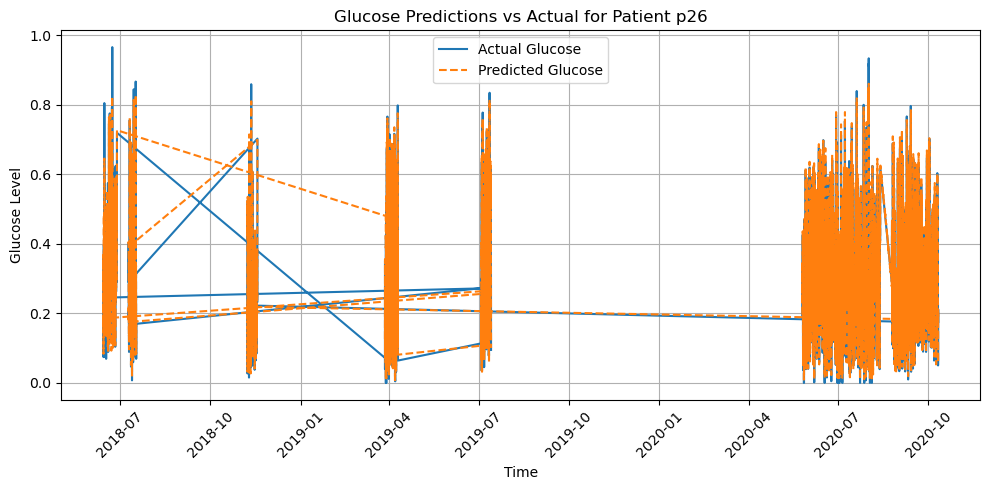

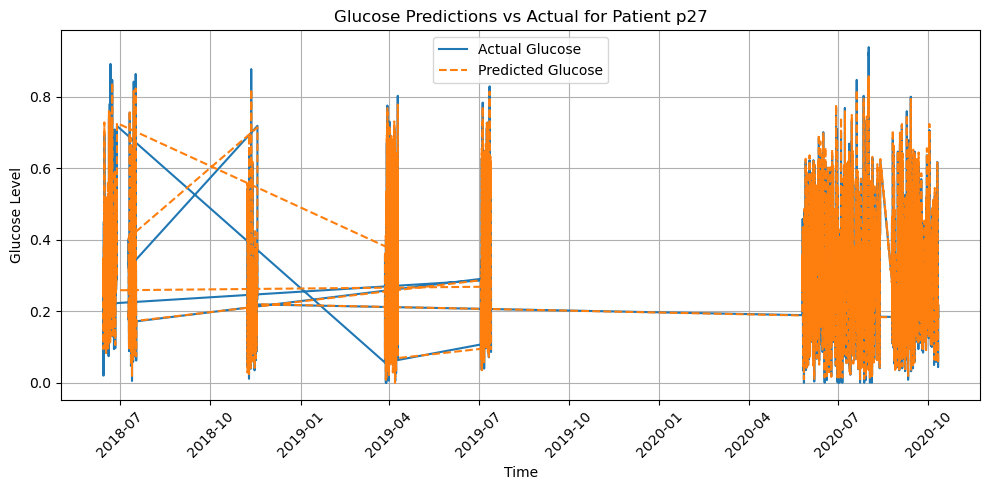

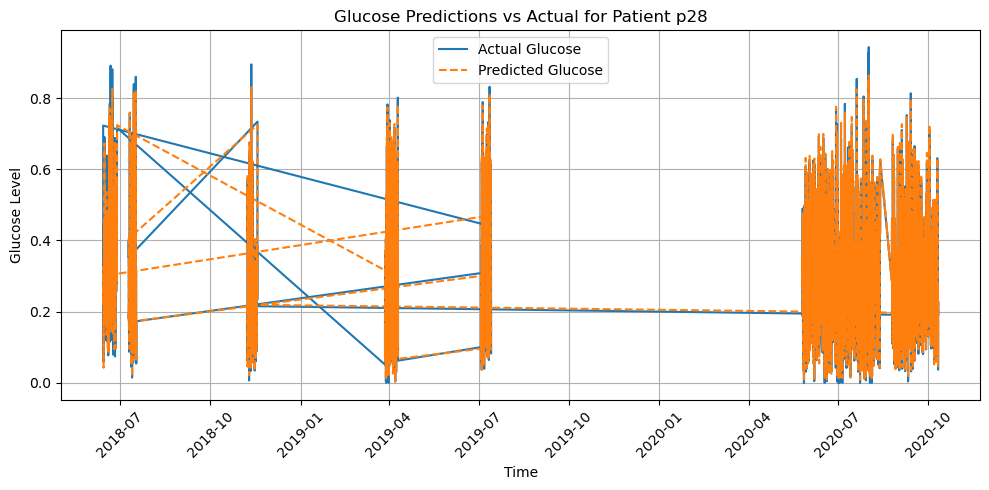

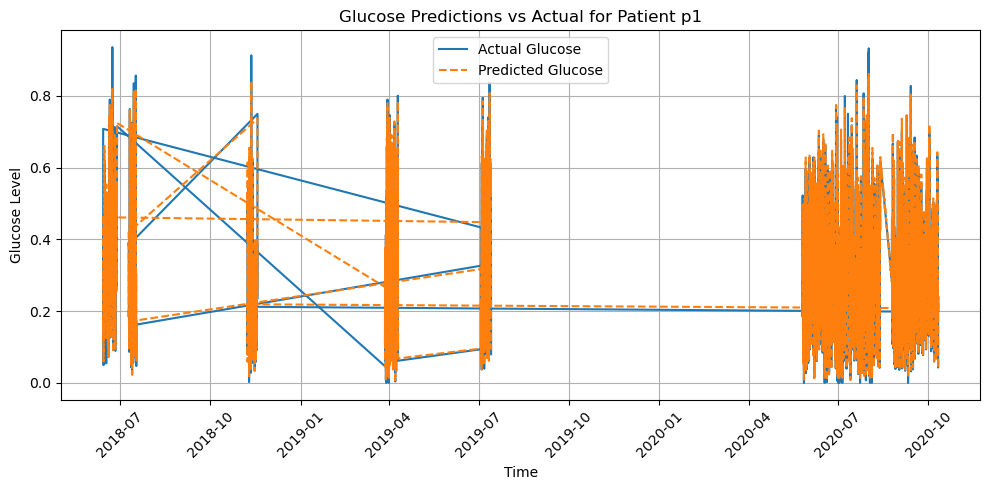

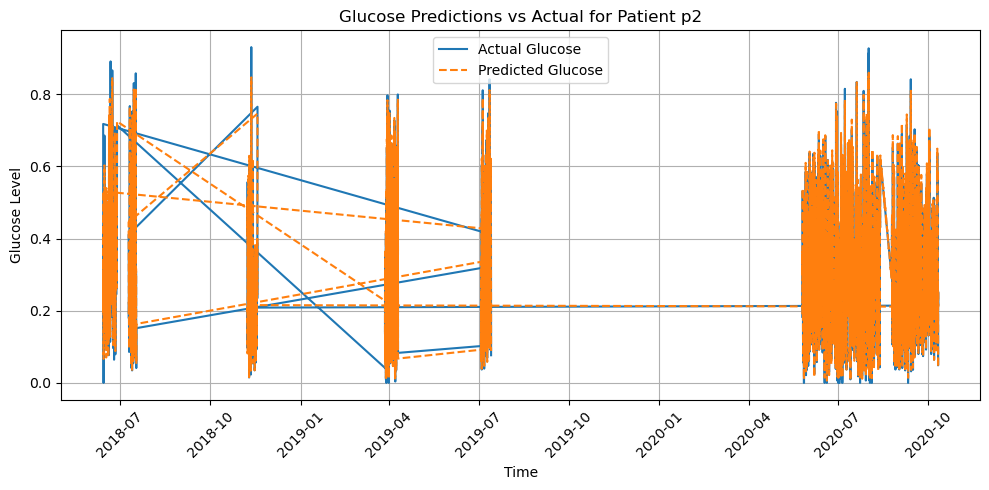

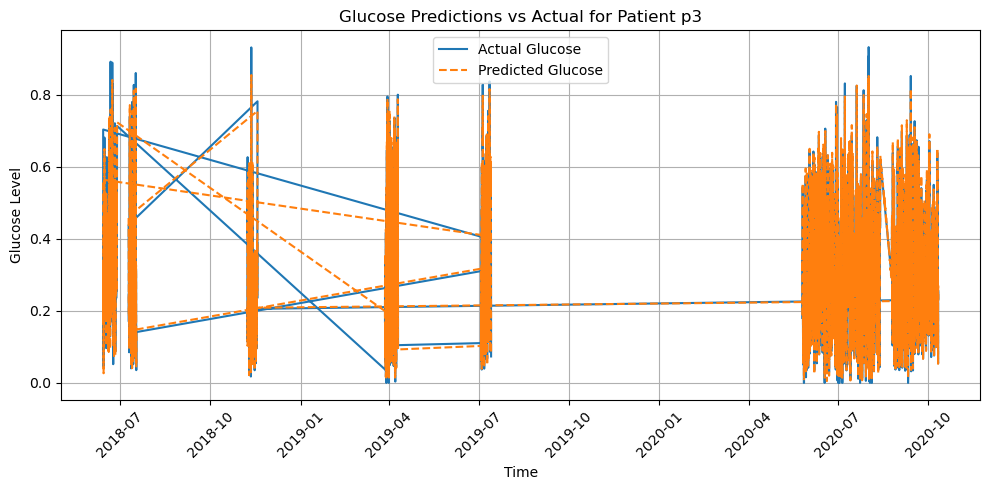

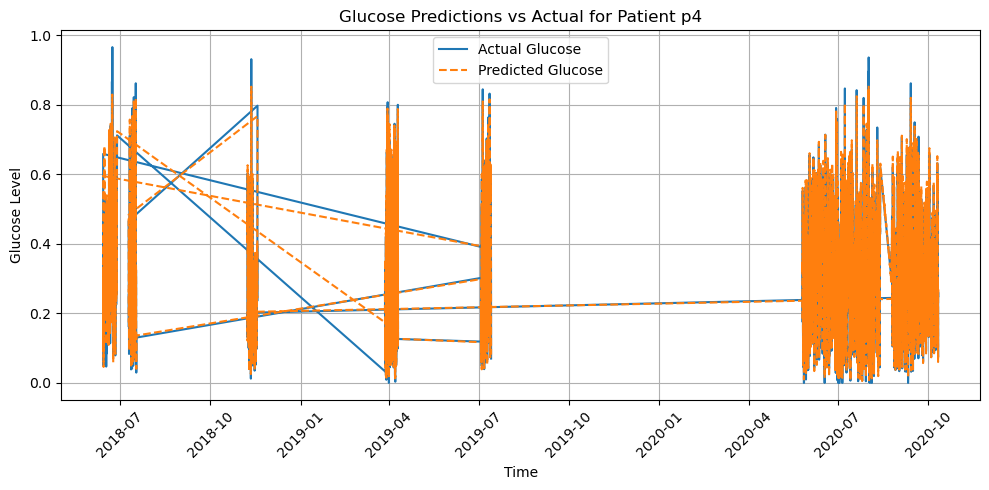

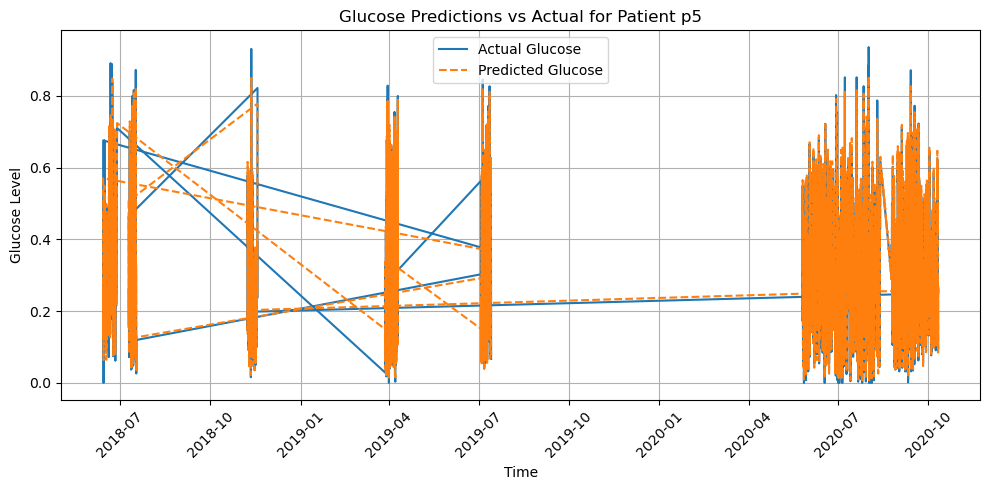

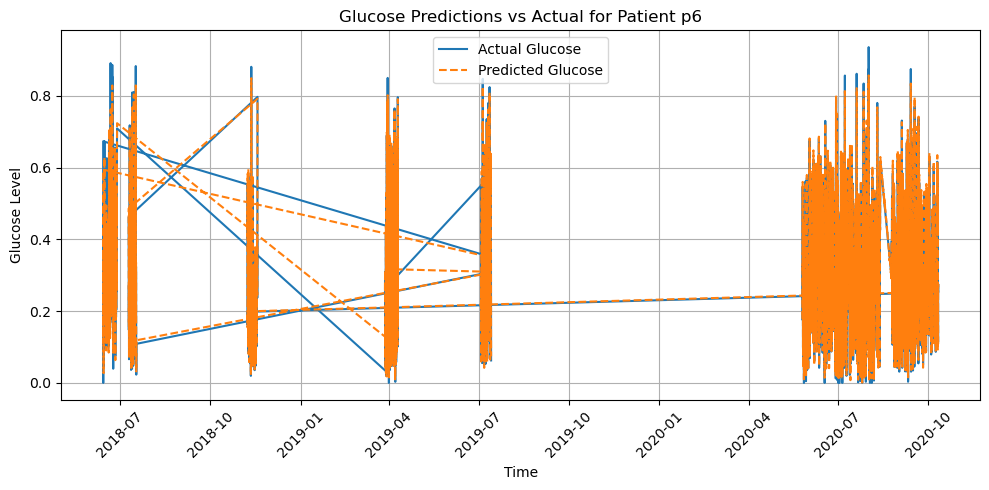

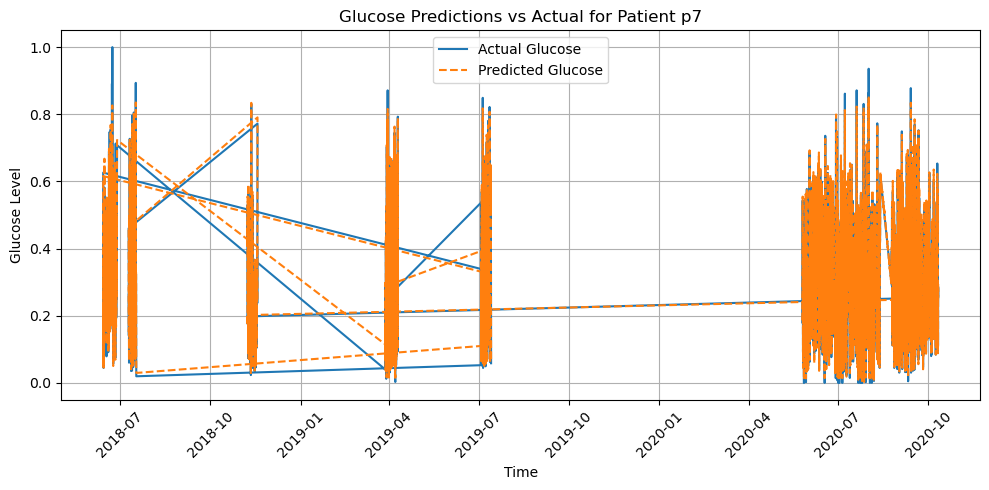

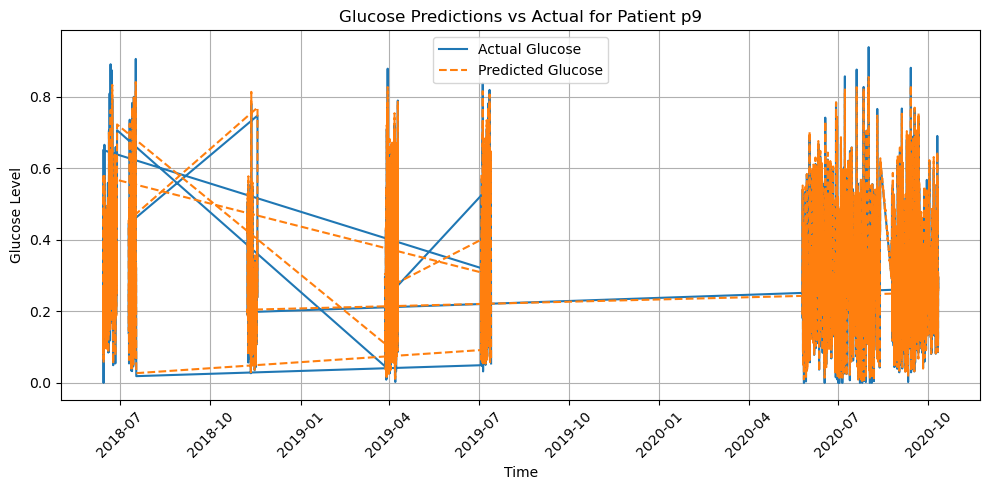

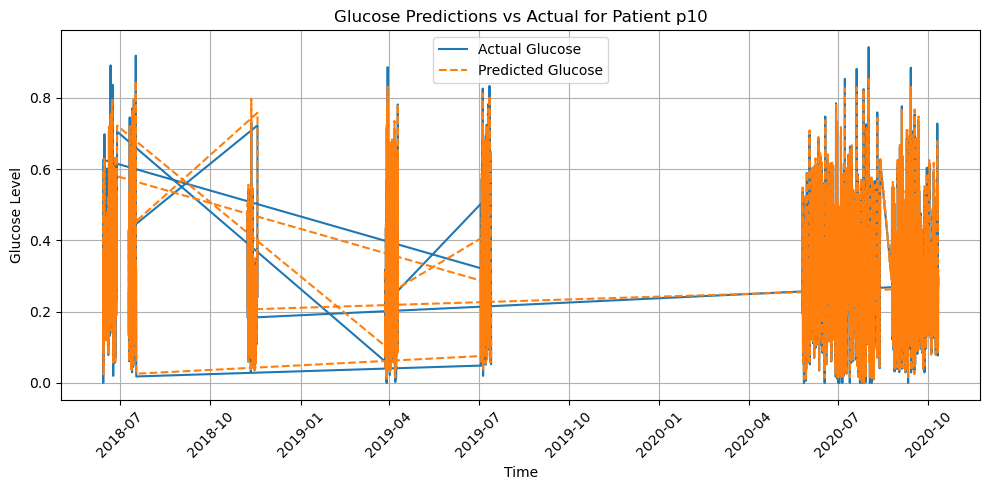

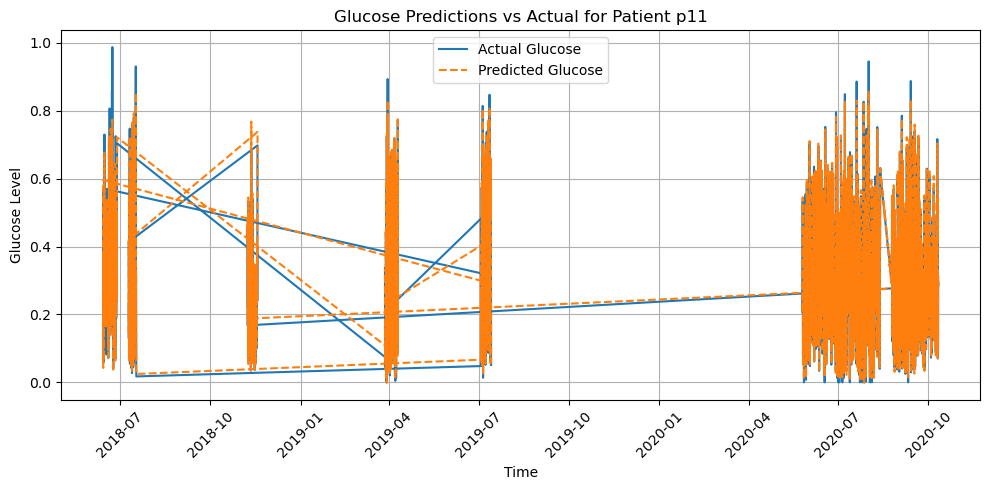

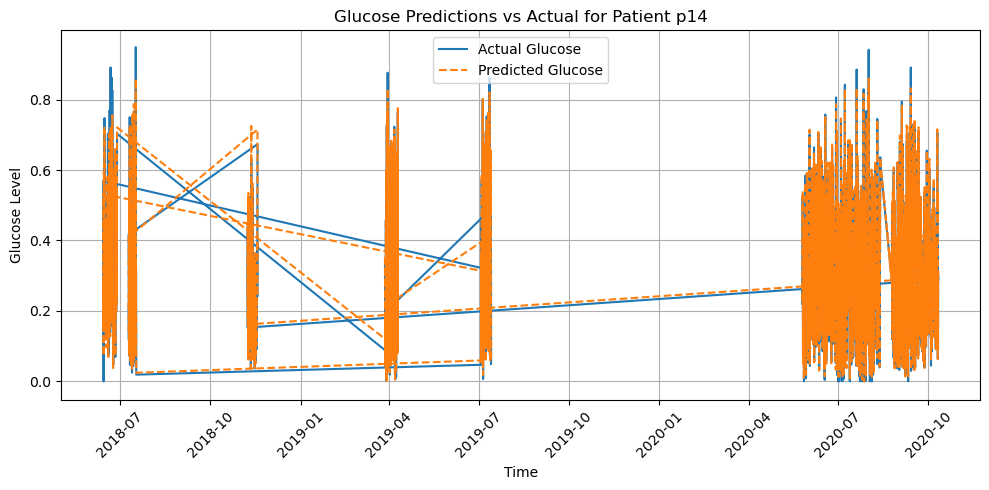

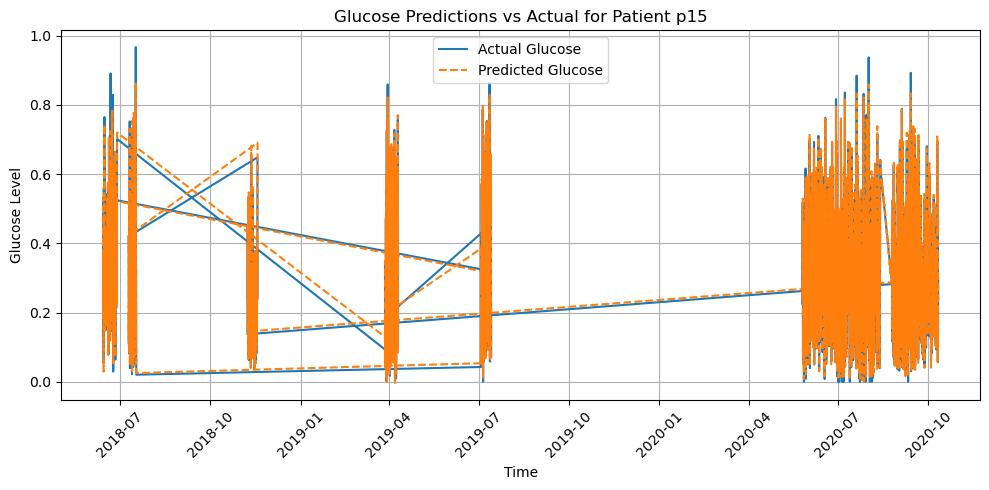

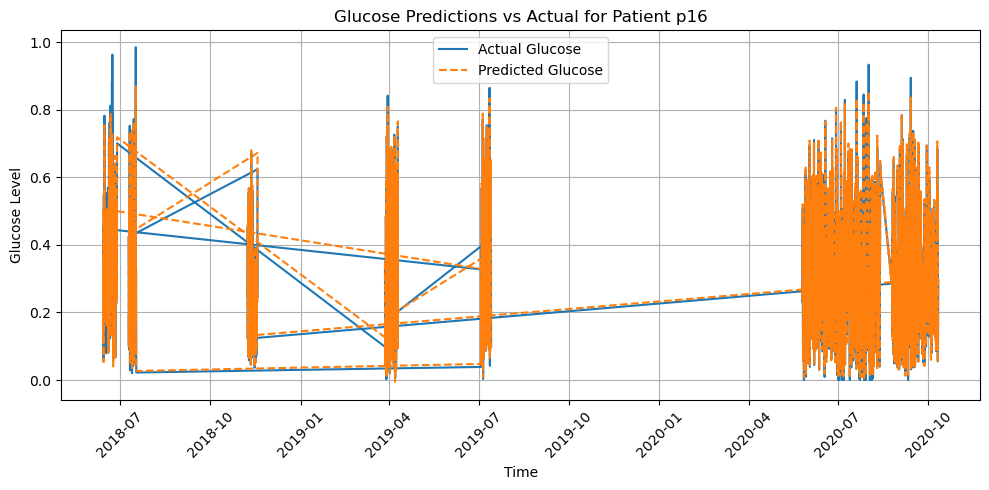

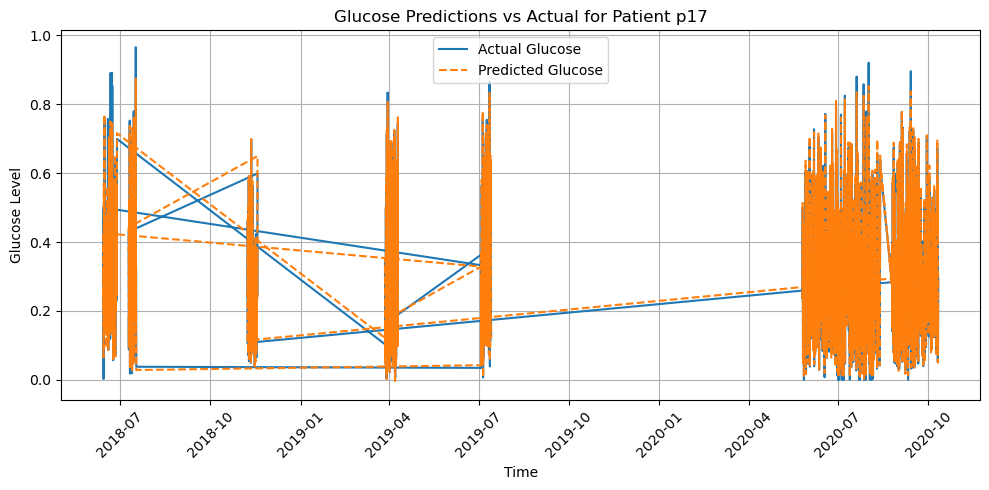

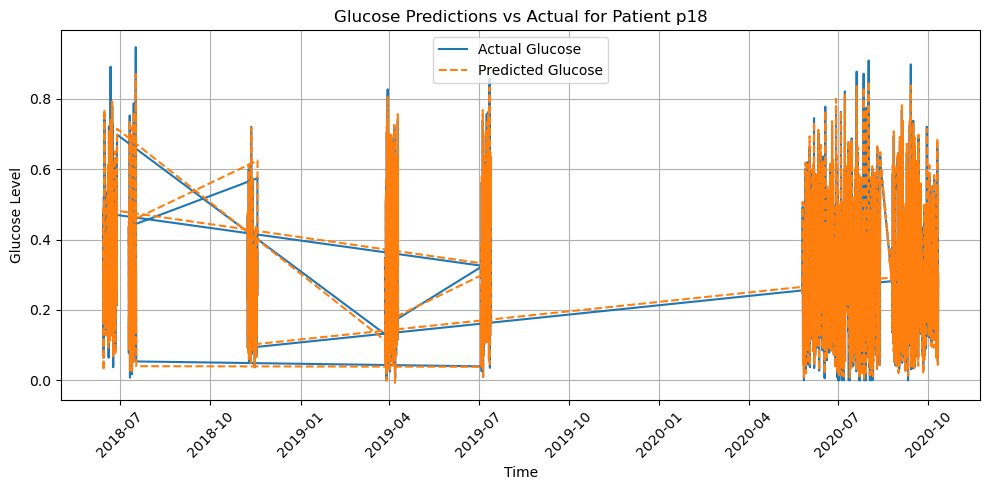

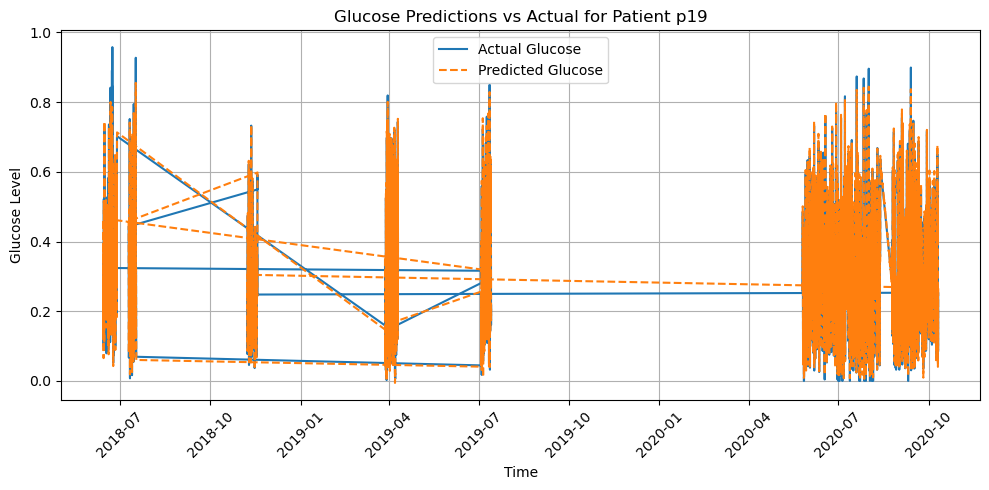

In [31]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout, BatchNormalization, Flatten, Attention
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

# Path to dataset
dataset_path = "/Users/zinaghottis/Downloads/HUPA-UCM Diabetes Dataset/Preprocessed"

# 1. Load and Merge Data
def load_and_merge_data(directory):
    all_data = []
    for file in os.listdir(directory):
        if file.endswith(".csv"):
            file_path = os.path.join(directory, file)
            data = pd.read_csv(file_path, delimiter=';')
            data['time'] = pd.to_datetime(data['time'], errors='coerce')
            all_data.append(data)
    return pd.concat(all_data, ignore_index=True)

# Load the dataset
data = load_and_merge_data(dataset_path)

# 2. Fix 'carb_input,Patient ID' column
data[['carb_input', 'Patient ID']] = data['carb_input,Patient ID'].str.split(',', expand=True)

# Convert 'carb_input' to numeric if it's not already
data['carb_input'] = pd.to_numeric(data['carb_input'], errors='coerce')

# Drop the original column
data.drop(columns=['carb_input,Patient ID'], inplace=True)

# 3. Feature Engineering
data['glucose_rate_of_change'] = data['glucose'].diff() / (data['time'].diff().dt.total_seconds() / 60)
data['insulin_carb_ratio'] = data['bolus_volume_delivered'] / (data['carb_input'] + 1e-6)
data['activity_intensity'] = data['heart_rate'] * data['steps']
data.dropna(inplace=True)

# Solution: Repeat patient IDs to match the number of rows in the dataset
patient_ids = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p9', 'p10', 'p11', 
               'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 
               'p23', 'p24', 'p25', 'p26', 'p27', 'p28']

# Repeat the patient IDs list enough times to cover all rows in the dataset
repeated_patient_ids = np.tile(patient_ids, int(np.ceil(len(data) / len(patient_ids))))

# Trim or slice to ensure it matches the exact length of the dataset
repeated_patient_ids = repeated_patient_ids[:len(data)]

# Assign to the DataFrame
data['Patient ID'] = repeated_patient_ids

# 4. Normalize Features
scaler = MinMaxScaler()
feature_columns = ['glucose', 'glucose_rate_of_change', 'insulin_carb_ratio', 'activity_intensity', 'calories', 'basal_rate']
data[feature_columns] = scaler.fit_transform(data[feature_columns])

# 5. Prepare Sequences for CNN-LSTM
def create_sequences(data, target_column, seq_length=20):
    X, y = [], []
    data = data.reset_index(drop=True)
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length][feature_columns].values)
        y.append(data.iloc[i+seq_length][target_column])
    return np.array(X), np.array(y)

X, y = create_sequences(data, target_column='glucose')

# 6. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

# 7. Define CNN-LSTM Model with Attention for Feature Extraction
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
cnn = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
cnn = BatchNormalization()(cnn)
cnn = Dropout(0.3)(cnn)
lstm = LSTM(128, return_sequences=True)(cnn)
attention = Attention()([lstm, lstm])  
flatten = Flatten()(attention)
dense = Dense(64, activation='relu')(flatten)
dense = Dropout(0.3)(dense)
output = Dense(1, activation='linear')(dense)

feature_extractor = Model(inputs, output)
feature_extractor.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 8. Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 9. Train the Model
history = feature_extractor.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

# 10. Make Predictions
y_pred = feature_extractor.predict(X_test)

# 11. Plot Results per Patient
# Add Patient ID to the test set for grouping
test_data = data.iloc[X_train.shape[0]+20:, :].reset_index(drop=True)  # Skip the first sequences (for training)
test_data['predictions'] = np.concatenate([y_pred])  # Add predictions to test data

# Loop over each patient and plot the results
unique_patients = test_data['Patient ID'].unique()

for patient in unique_patients:
    patient_data = test_data[test_data['Patient ID'] == patient]
    
    plt.figure(figsize=(10, 5))
    plt.plot(patient_data['time'], patient_data['glucose'], label='Actual Glucose')
    plt.plot(patient_data['time'], patient_data['predictions'], label='Predicted Glucose', linestyle='dashed')
    
    plt.title(f"Glucose Predictions vs Actual for Patient {patient}")
    plt.xlabel('Time')
    plt.ylabel('Glucose Level')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Epoch 1/10
3868/3868 ━━━━━━━━━━━━━━━━━━━━ 126s 31ms/step - loss: 0.0529 - mae: 0.1287 - val_loss: 5.0373e-04 - val_mae: 0.0135
Epoch 2/10
3868/3868 ━━━━━━━━━━━━━━━━━━━━ 96s 25ms/step - loss: 9.4395e-04 - mae: 0.0230 - val_loss: 0.0059 - val_mae: 0.0608
Epoch 3/10
3868/3868 ━━━━━━━━━━━━━━━━━━━━ 2220s 574ms/step - loss: 0.0015 - mae: 0.0289 - val_loss: 0.0016 - val_mae: 0.0307
Epoch 4/10
3868/3868 ━━━━━━━━━━━━━━━━━━━━ 105s 27ms/step - loss: 0.0018 - mae: 0.0311 - val_loss: 0.0036 - val_mae: 0.0530
Epoch 5/10
3868/3868 ━━━━━━━━━━━━━━━━━━━━ 151s 39ms/step - loss: 0.0019 - mae: 0.0318 - val_loss: 0.0029 - val_mae: 0.0389
Epoch 6/10
3868/3868 ━━━━━━━━━━━━━━━━━━━━ 114s 29ms/step - loss: 0.0028 - mae: 0.0348 - val_loss: 0.0016 - val_mae: 0.0300


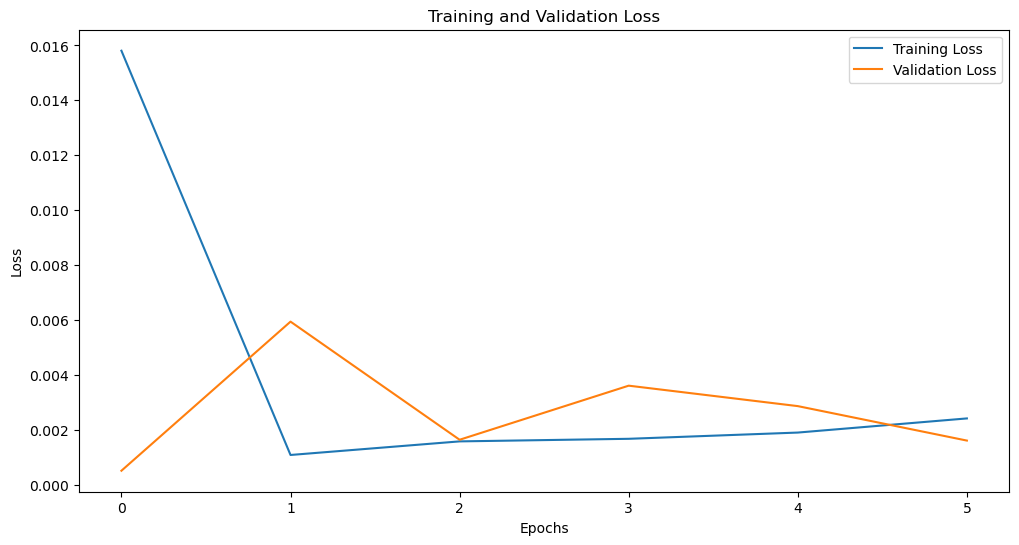

1934/1934 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - loss: 3.2613e-04 - mae: 0.0122
Test Loss: 0.000503730378113687
Test MAE: 0.013519995845854282


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout, BatchNormalization, Flatten, Attention
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Path to dataset
dataset_path = "/Users/zinaghottis/Downloads/HUPA-UCM Diabetes Dataset/Preprocessed"

# 1. Load and Merge Data
def load_and_merge_data(directory):
    all_data = []
    for file in os.listdir(directory):
        if file.endswith(".csv"):
            file_path = os.path.join(directory, file)
            data = pd.read_csv(file_path, delimiter=';')
            data['time'] = pd.to_datetime(data['time'], errors='coerce')
            all_data.append(data)
    return pd.concat(all_data, ignore_index=True)

# Load the dataset
data = load_and_merge_data(dataset_path)

# 2. Fix 'carb_input,Patient ID' column
data[['carb_input', 'Patient ID']] = data['carb_input,Patient ID'].str.split(',', expand=True)

# Convert 'carb_input' to numeric if it's not already
data['carb_input'] = pd.to_numeric(data['carb_input'], errors='coerce')

# Drop the original column
data.drop(columns=['carb_input,Patient ID'], inplace=True)

# 3. Feature Engineering
data['glucose_rate_of_change'] = data['glucose'].diff() / (data['time'].diff().dt.total_seconds() / 60)
data['insulin_carb_ratio'] = data['bolus_volume_delivered'] / (data['carb_input'] + 1e-6)
data['activity_intensity'] = data['heart_rate'] * data['steps']
data.dropna(inplace=True)

# Solution: Repeat patient IDs to match the number of rows in the dataset
patient_ids = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p9', 'p10', 'p11', 
               'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 
               'p23', 'p24', 'p25', 'p26', 'p27', 'p28']

# Repeat the patient IDs list enough times to cover all rows in the dataset
repeated_patient_ids = np.tile(patient_ids, int(np.ceil(len(data) / len(patient_ids))))

# Trim or slice to ensure it matches the exact length of the dataset
repeated_patient_ids = repeated_patient_ids[:len(data)]

# Assign to the DataFrame
data['Patient ID'] = repeated_patient_ids

# 4. Normalize Features
scaler = MinMaxScaler()
feature_columns = ['glucose', 'glucose_rate_of_change', 'insulin_carb_ratio', 'activity_intensity', 'calories', 'basal_rate']
data[feature_columns] = scaler.fit_transform(data[feature_columns])

# 5. Prepare Sequences for CNN-LSTM
def create_sequences(data, target_column, seq_length=20):
    X, y = [], []
    data = data.reset_index(drop=True)
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length][feature_columns].values)
        y.append(data.iloc[i+seq_length][target_column])
    return np.array(X), np.array(y)

X, y = create_sequences(data, target_column='glucose')

# 6. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

# 7. Define CNN-LSTM Model with Attention for Feature Extraction
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
cnn = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
cnn = BatchNormalization()(cnn)
cnn = Dropout(0.3)(cnn)
lstm = LSTM(128, return_sequences=True)(cnn)
attention = Attention()([lstm, lstm])  
flatten = Flatten()(attention)
dense = Dense(64, activation='relu')(flatten)
dense = Dropout(0.3)(dense)
output = Dense(1, activation='linear')(dense)

feature_extractor = Model(inputs, output)
feature_extractor.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 8. Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 9. Train the Model
history = feature_extractor.fit(
    X_train, 
    y_train, 
    epochs=10, 
    batch_size=64, 
    validation_data=(X_test, y_test), 
    callbacks=[early_stopping]
)

# 10. Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 11. Evaluate the Model
loss, mae = feature_extractor.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test MAE: {mae}")




Epoch 1/20
3868/3868 ━━━━━━━━━━━━━━━━━━━━ 80s 20ms/step - loss: 0.0546 - mae: 0.1304 - val_loss: 0.0027 - val_mae: 0.0373
Epoch 2/20
3868/3868 ━━━━━━━━━━━━━━━━━━━━ 77s 20ms/step - loss: 0.0015 - mae: 0.0293 - val_loss: 8.3235e-04 - val_mae: 0.0194
Epoch 3/20
3868/3868 ━━━━━━━━━━━━━━━━━━━━ 77s 20ms/step - loss: 0.0020 - mae: 0.0326 - val_loss: 0.0091 - val_mae: 0.0766
Epoch 4/20
3868/3868 ━━━━━━━━━━━━━━━━━━━━ 84s 22ms/step - loss: 0.0026 - mae: 0.0373 - val_loss: 0.0055 - val_mae: 0.0612
Epoch 5/20
3868/3868 ━━━━━━━━━━━━━━━━━━━━ 81s 21ms/step - loss: 0.0030 - mae: 0.0384 - val_loss: 0.0029 - val_mae: 0.0420
Epoch 6/20
3868/3868 ━━━━━━━━━━━━━━━━━━━━ 81s 21ms/step - loss: 0.0032 - mae: 0.0411 - val_loss: 0.0012 - val_mae: 0.0231
Epoch 7/20
3868/3868 ━━━━━━━━━━━━━━━━━━━━ 145s 37ms/step - loss: 0.0032 - mae: 0.0404 - val_loss: 0.0014 - val_mae: 0.0262
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 118s 15ms/step - loss: 4.3001e-04 - mae: 0.0160
1934/1934 ━━━━━━━━━━━━━━━━━━━━ 31s 16ms/step - loss: 5.7091e-0

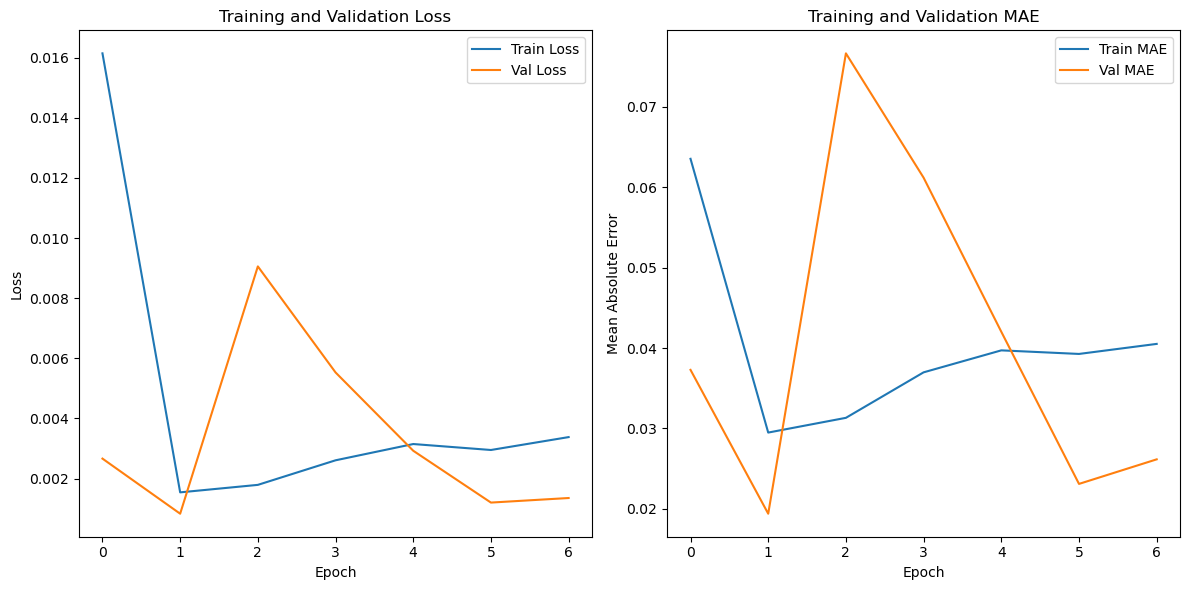

/var/folders/sg/f70605tj49gf5qq225kwnddh0000gn/T/ipykernel_6841/2123841440.py:152: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



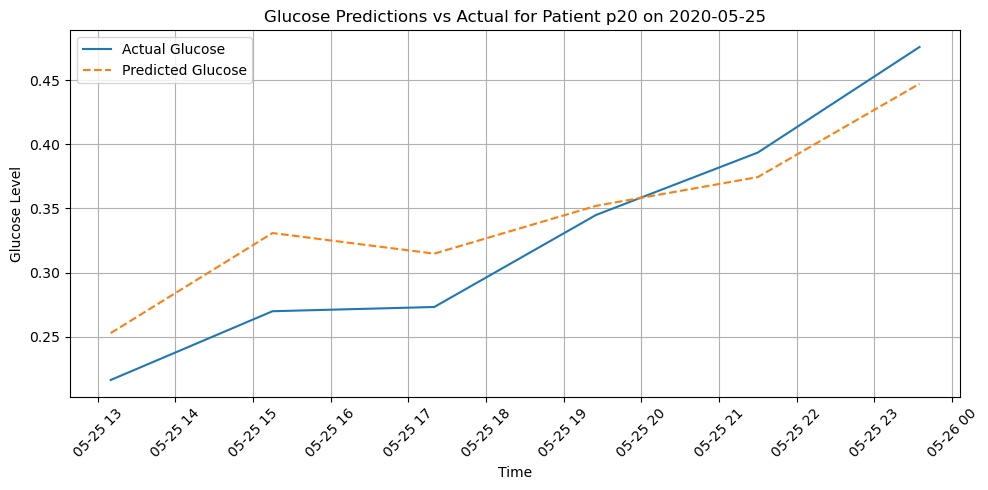

/var/folders/sg/f70605tj49gf5qq225kwnddh0000gn/T/ipykernel_6841/2123841440.py:152: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



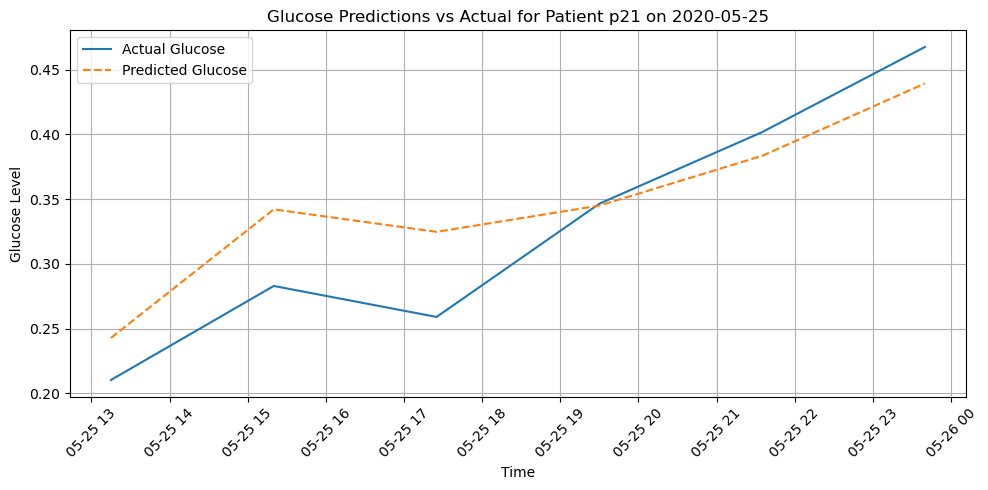

/var/folders/sg/f70605tj49gf5qq225kwnddh0000gn/T/ipykernel_6841/2123841440.py:152: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



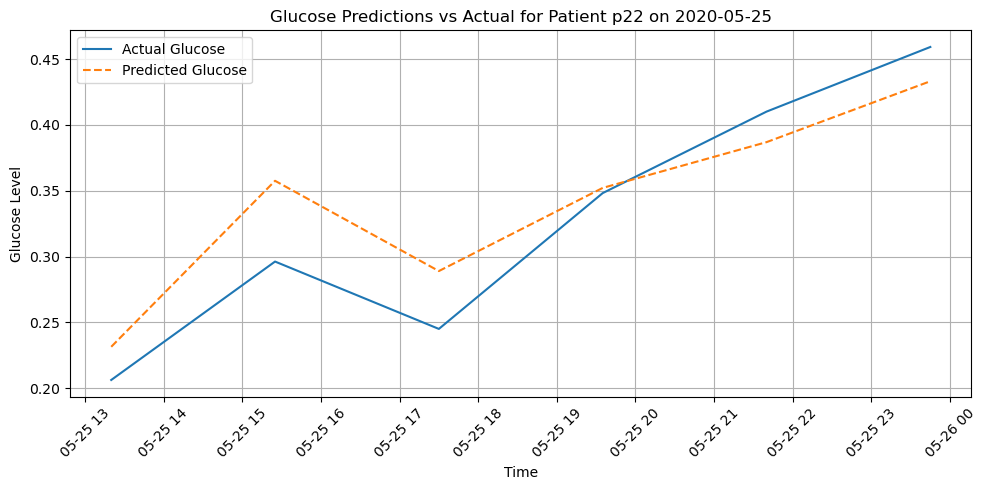

/var/folders/sg/f70605tj49gf5qq225kwnddh0000gn/T/ipykernel_6841/2123841440.py:152: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



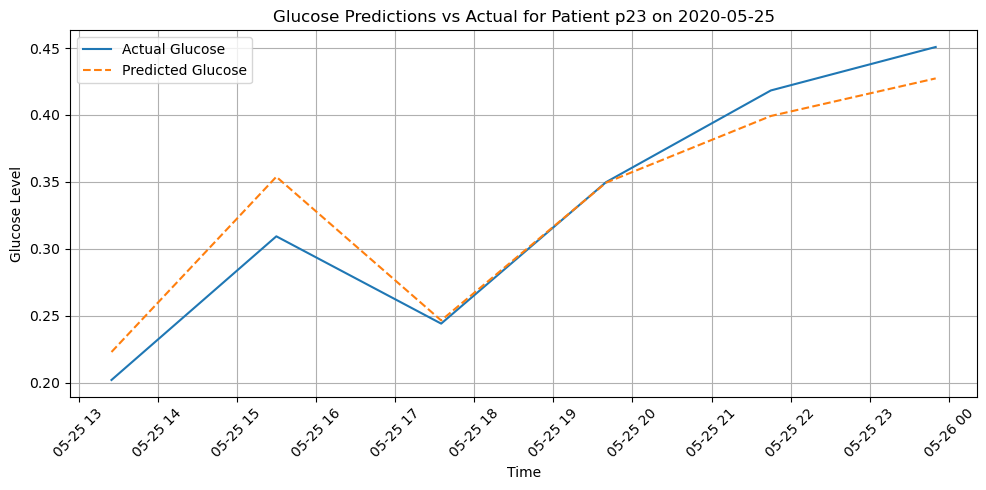

/var/folders/sg/f70605tj49gf5qq225kwnddh0000gn/T/ipykernel_6841/2123841440.py:152: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



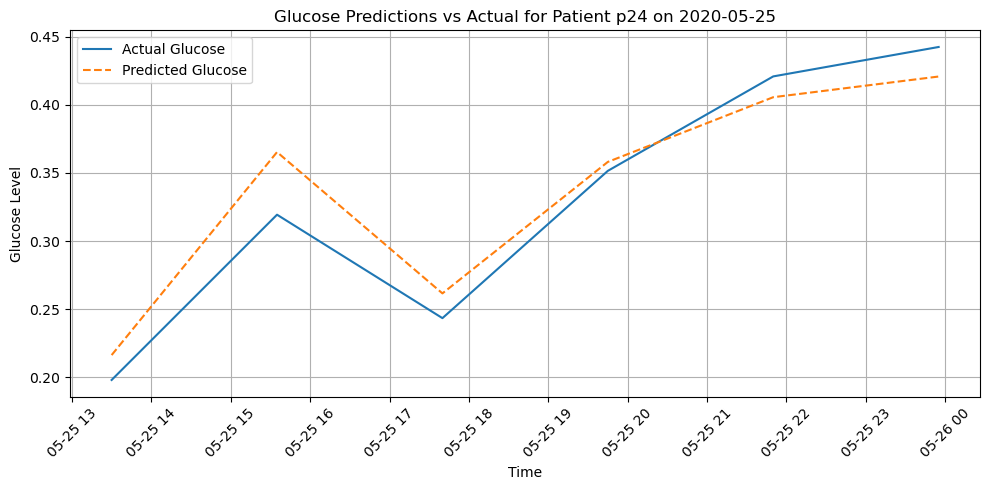

/var/folders/sg/f70605tj49gf5qq225kwnddh0000gn/T/ipykernel_6841/2123841440.py:152: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



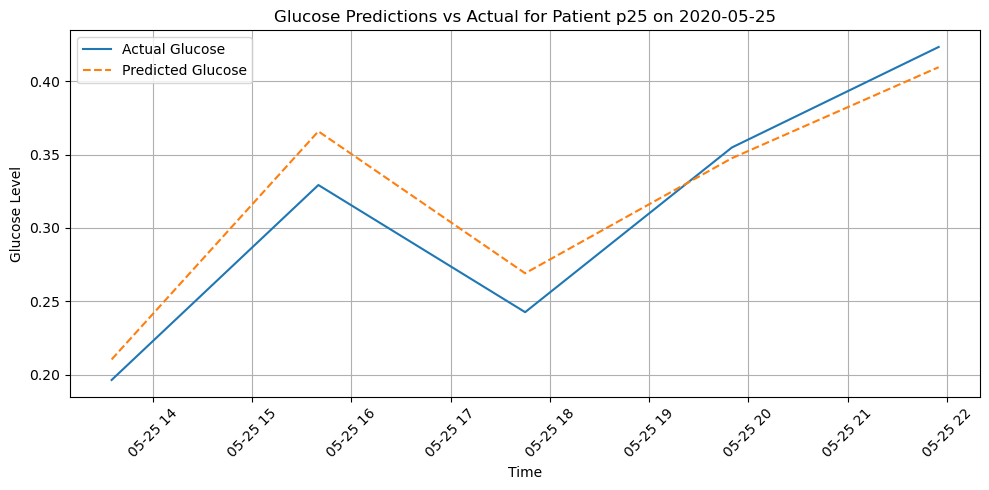

/var/folders/sg/f70605tj49gf5qq225kwnddh0000gn/T/ipykernel_6841/2123841440.py:152: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



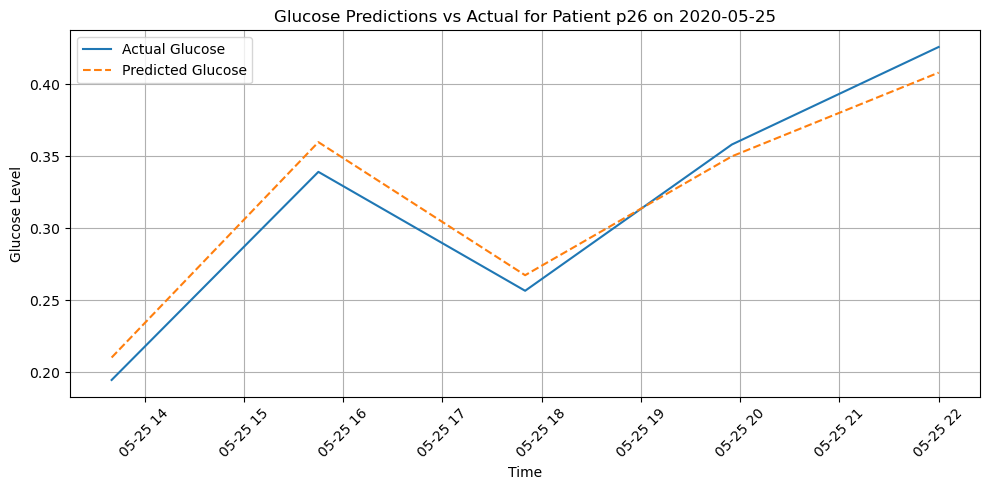

/var/folders/sg/f70605tj49gf5qq225kwnddh0000gn/T/ipykernel_6841/2123841440.py:152: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



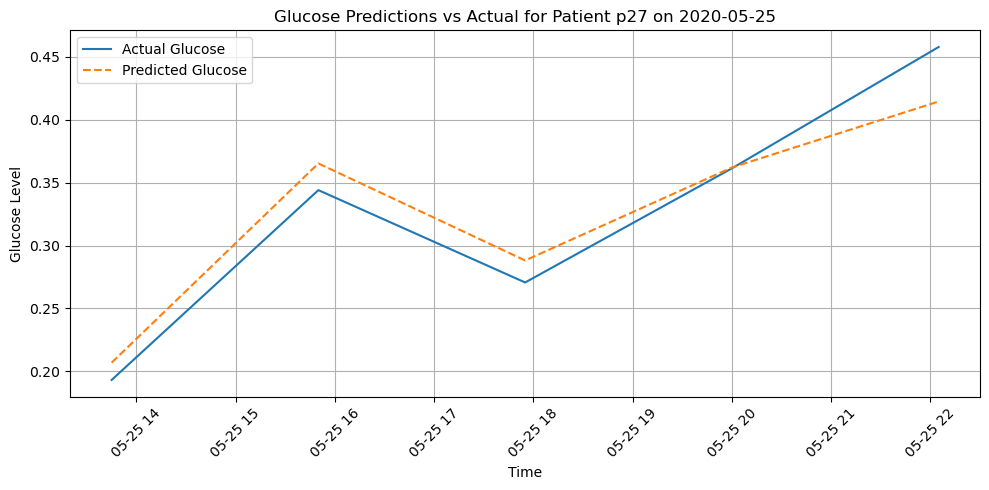

/var/folders/sg/f70605tj49gf5qq225kwnddh0000gn/T/ipykernel_6841/2123841440.py:152: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



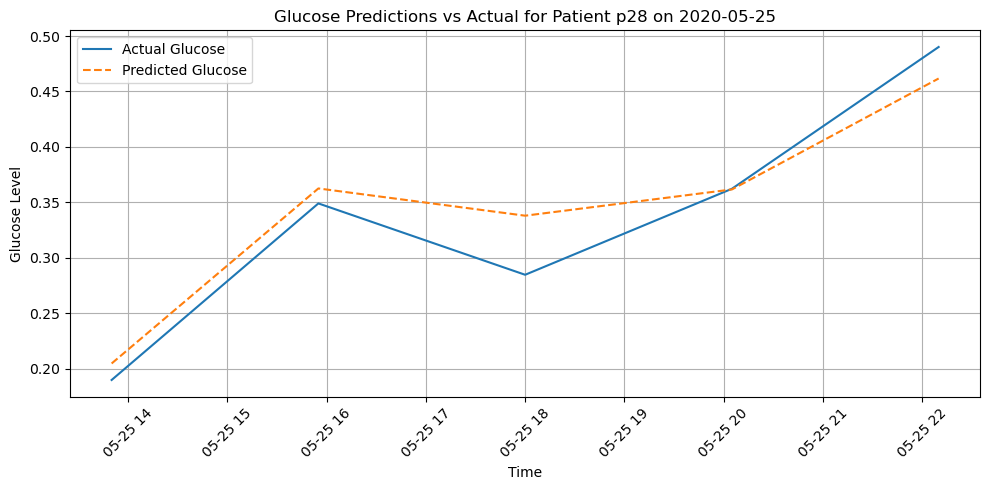

/var/folders/sg/f70605tj49gf5qq225kwnddh0000gn/T/ipykernel_6841/2123841440.py:152: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



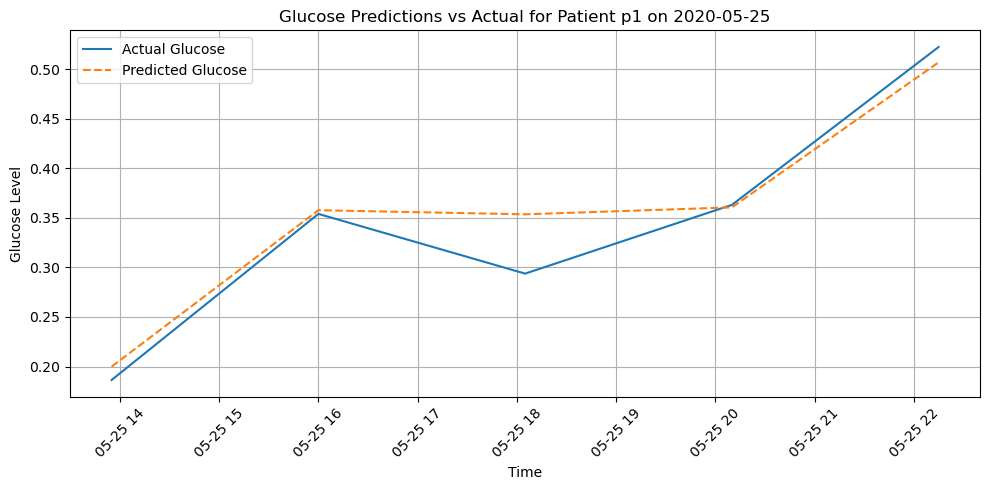

/var/folders/sg/f70605tj49gf5qq225kwnddh0000gn/T/ipykernel_6841/2123841440.py:152: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



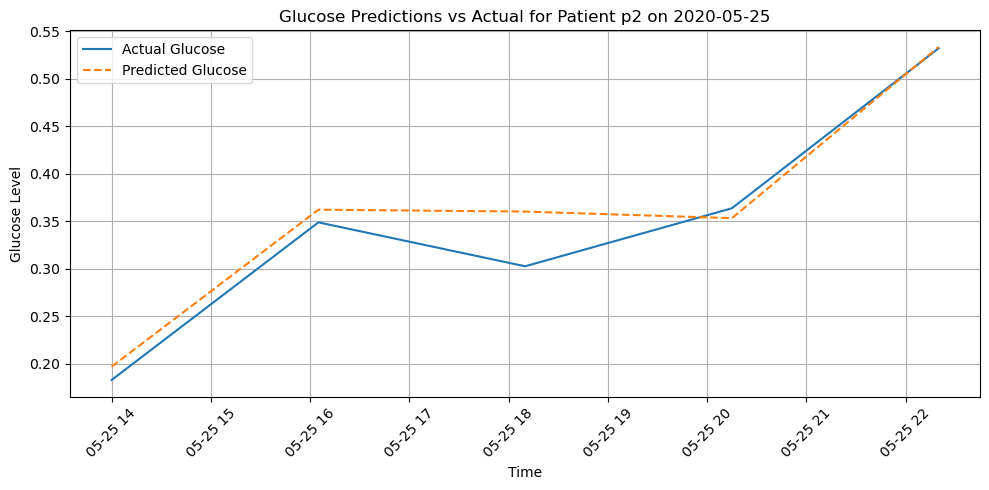

/var/folders/sg/f70605tj49gf5qq225kwnddh0000gn/T/ipykernel_6841/2123841440.py:152: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



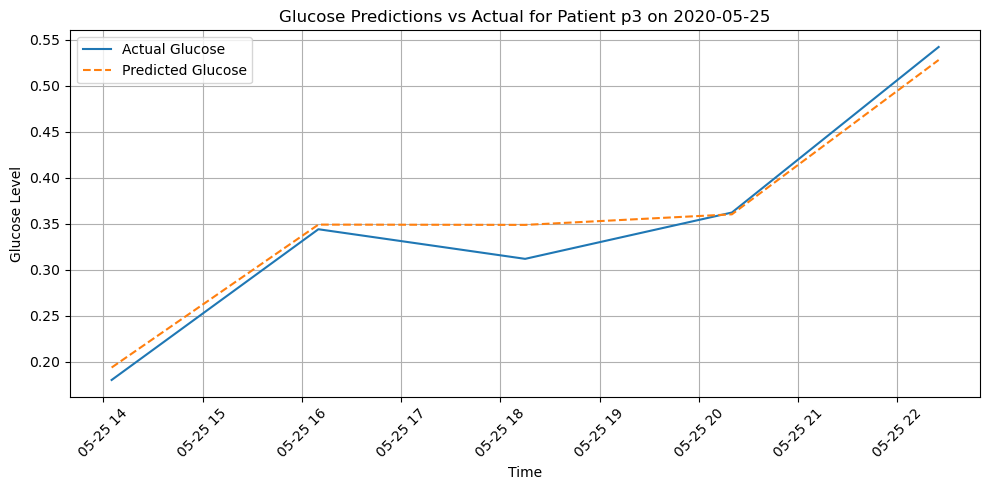

/var/folders/sg/f70605tj49gf5qq225kwnddh0000gn/T/ipykernel_6841/2123841440.py:152: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



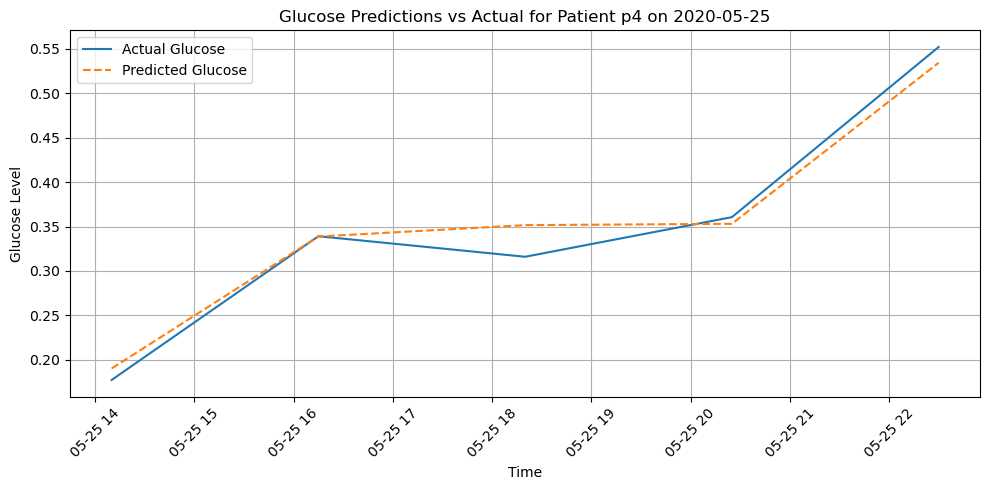

/var/folders/sg/f70605tj49gf5qq225kwnddh0000gn/T/ipykernel_6841/2123841440.py:152: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



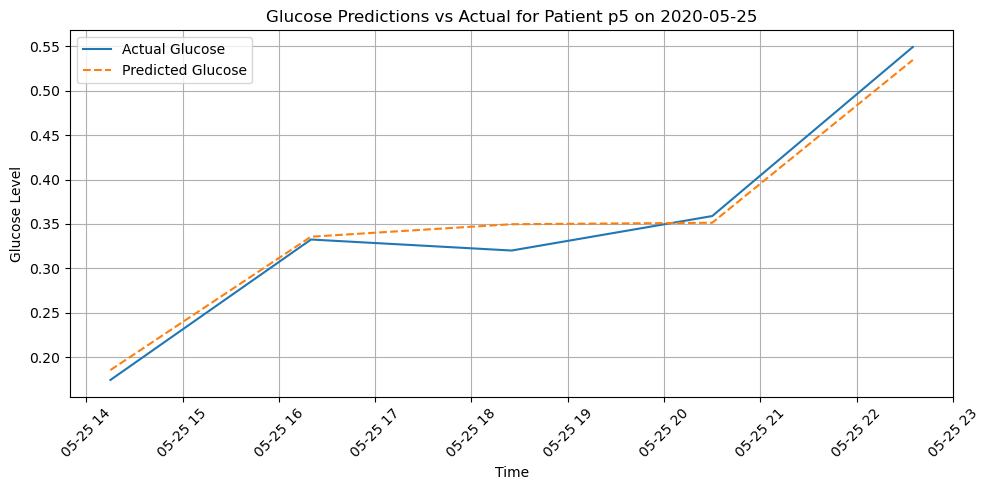

/var/folders/sg/f70605tj49gf5qq225kwnddh0000gn/T/ipykernel_6841/2123841440.py:152: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



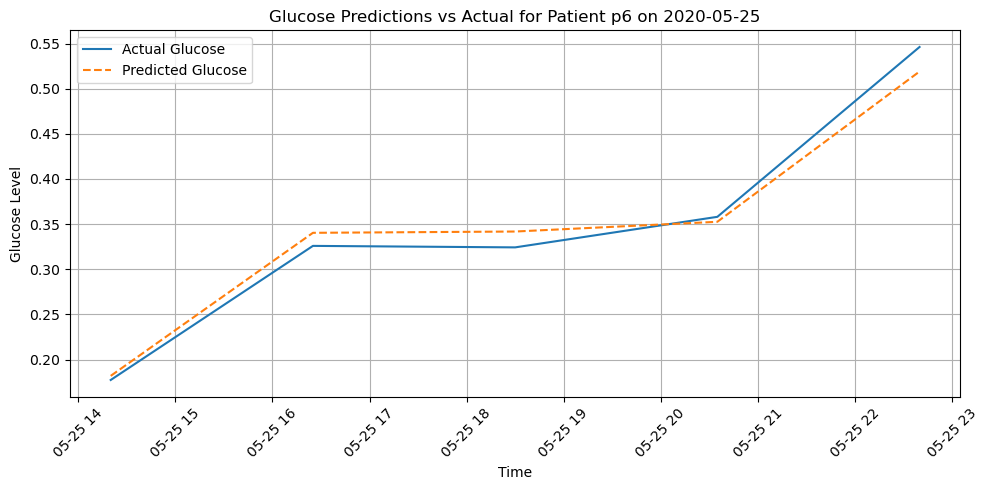

/var/folders/sg/f70605tj49gf5qq225kwnddh0000gn/T/ipykernel_6841/2123841440.py:152: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



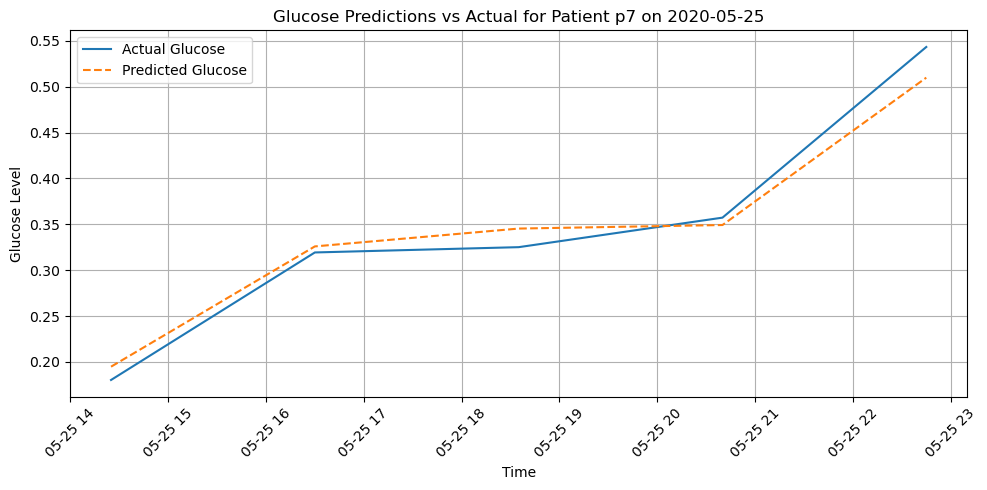

/var/folders/sg/f70605tj49gf5qq225kwnddh0000gn/T/ipykernel_6841/2123841440.py:152: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



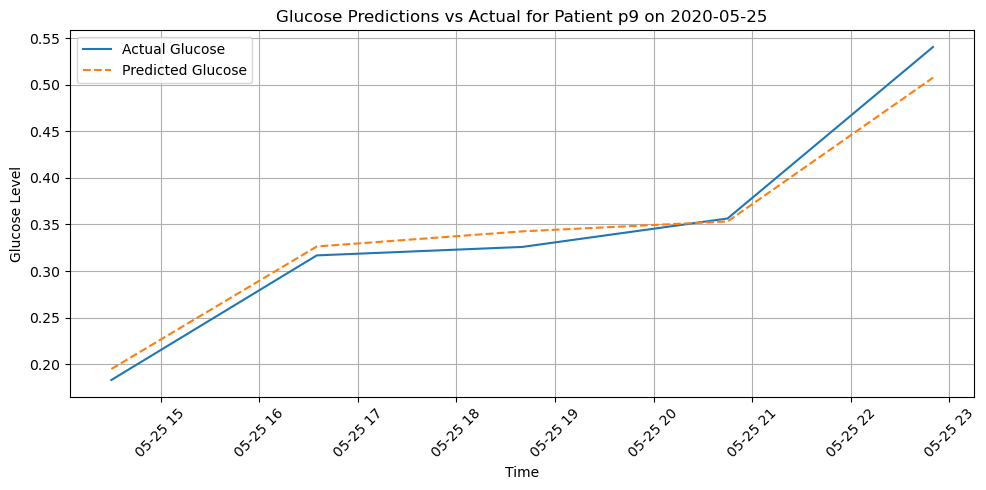

/var/folders/sg/f70605tj49gf5qq225kwnddh0000gn/T/ipykernel_6841/2123841440.py:152: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



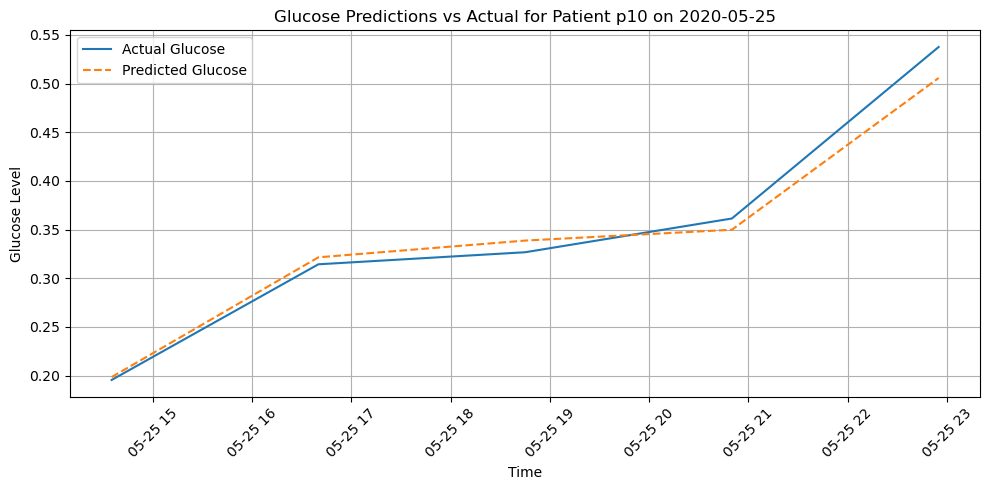

/var/folders/sg/f70605tj49gf5qq225kwnddh0000gn/T/ipykernel_6841/2123841440.py:152: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



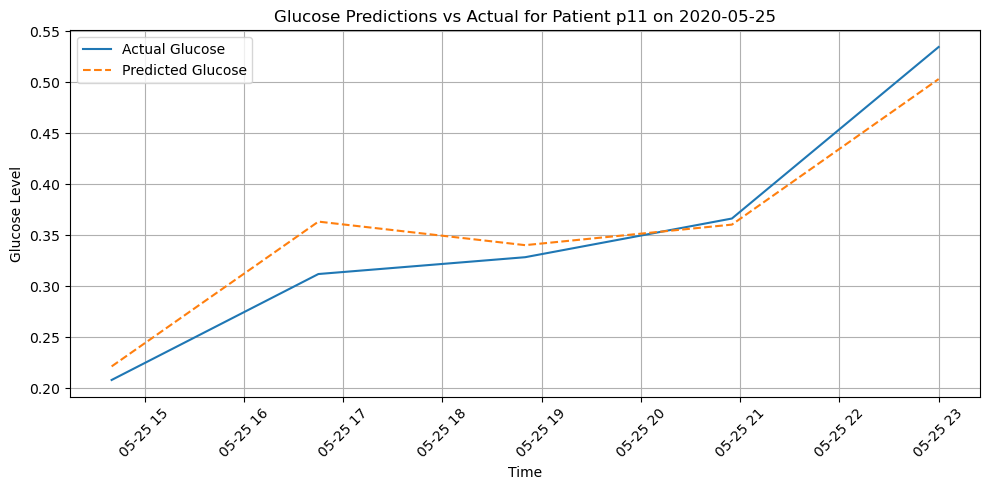

/var/folders/sg/f70605tj49gf5qq225kwnddh0000gn/T/ipykernel_6841/2123841440.py:152: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



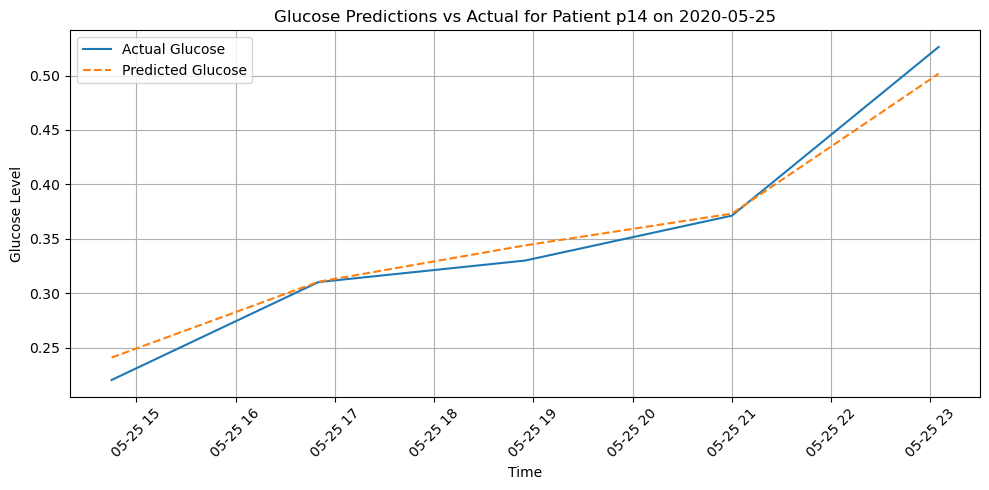

/var/folders/sg/f70605tj49gf5qq225kwnddh0000gn/T/ipykernel_6841/2123841440.py:152: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



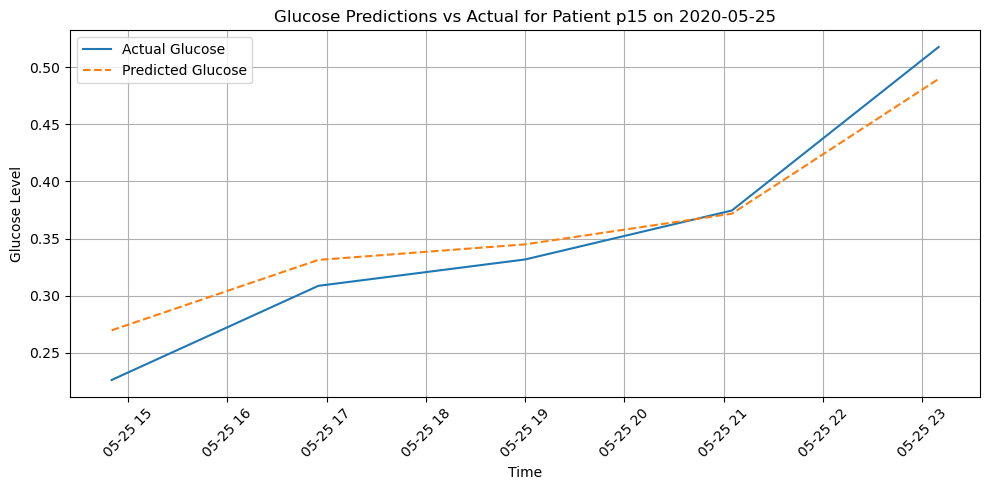

/var/folders/sg/f70605tj49gf5qq225kwnddh0000gn/T/ipykernel_6841/2123841440.py:152: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



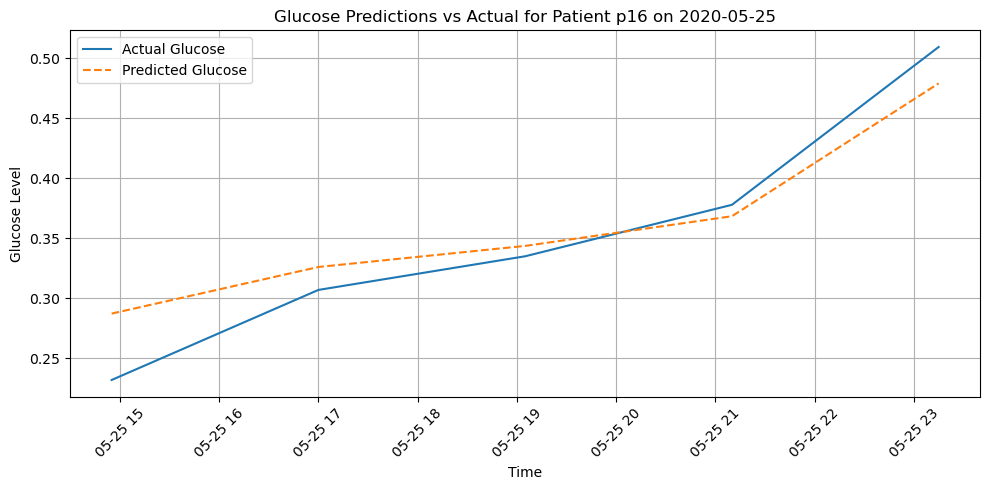

/var/folders/sg/f70605tj49gf5qq225kwnddh0000gn/T/ipykernel_6841/2123841440.py:152: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



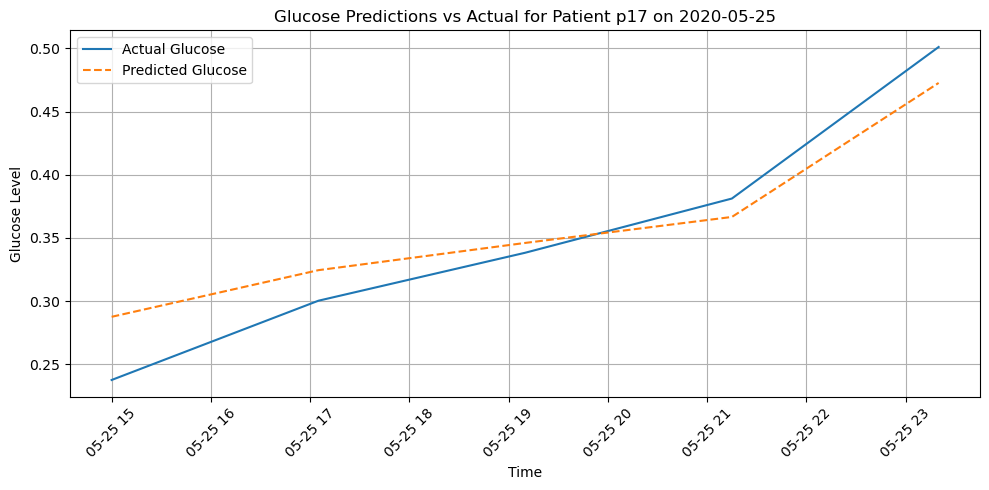

/var/folders/sg/f70605tj49gf5qq225kwnddh0000gn/T/ipykernel_6841/2123841440.py:152: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



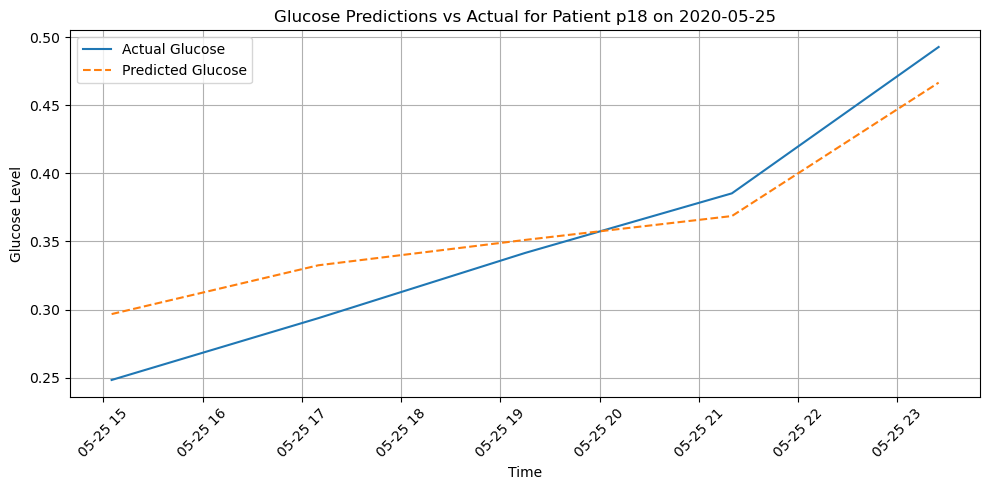

/var/folders/sg/f70605tj49gf5qq225kwnddh0000gn/T/ipykernel_6841/2123841440.py:152: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



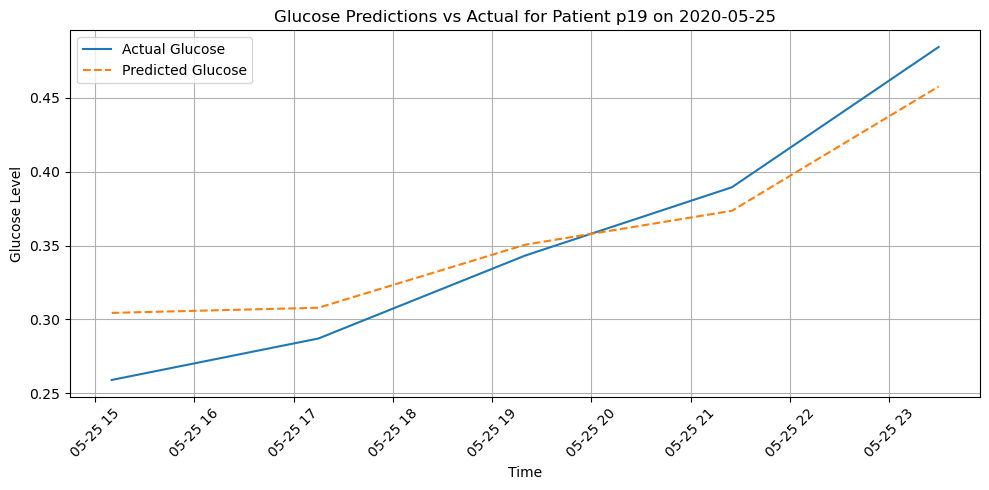

In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout, BatchNormalization, Flatten, Attention
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

# Path to dataset
dataset_path = "/Users/zinaghottis/Downloads/HUPA-UCM Diabetes Dataset/Preprocessed"

# 1. Load and Merge Data
def load_and_merge_data(directory):
    all_data = []
    for file in os.listdir(directory):
        if file.endswith(".csv"):
            file_path = os.path.join(directory, file)
            data = pd.read_csv(file_path, delimiter=';')
            data['time'] = pd.to_datetime(data['time'], errors='coerce')
            all_data.append(data)
    return pd.concat(all_data, ignore_index=True)

# Load the dataset
data = load_and_merge_data(dataset_path)

# 2. Fix 'carb_input,Patient ID' column
data[['carb_input', 'Patient ID']] = data['carb_input,Patient ID'].str.split(',', expand=True)

# Convert 'carb_input' to numeric if it's not already
data['carb_input'] = pd.to_numeric(data['carb_input'], errors='coerce')

# Drop the original column
data.drop(columns=['carb_input,Patient ID'], inplace=True)

# 3. Feature Engineering
data['glucose_rate_of_change'] = data['glucose'].diff() / (data['time'].diff().dt.total_seconds() / 60)
data['insulin_carb_ratio'] = data['bolus_volume_delivered'] / (data['carb_input'] + 1e-6)
data['activity_intensity'] = data['heart_rate'] * data['steps']
data.dropna(inplace=True)

# Solution: Repeat patient IDs to match the number of rows in the dataset
patient_ids = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p9', 'p10', 'p11', 
               'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 
               'p23', 'p24', 'p25', 'p26', 'p27', 'p28']

# Repeat the patient IDs list enough times to cover all rows in the dataset
repeated_patient_ids = np.tile(patient_ids, int(np.ceil(len(data) / len(patient_ids))))

# Trim or slice to ensure it matches the exact length of the dataset
repeated_patient_ids = repeated_patient_ids[:len(data)]

# Assign to the DataFrame
data['Patient ID'] = repeated_patient_ids

# 4. Normalize Features
scaler = MinMaxScaler()
feature_columns = ['glucose', 'glucose_rate_of_change', 'insulin_carb_ratio', 'activity_intensity', 'calories', 'basal_rate']
data[feature_columns] = scaler.fit_transform(data[feature_columns])

# 5. Prepare Sequences for CNN-LSTM
def create_sequences(data, target_column, seq_length=20):
    X, y = [], []
    data = data.reset_index(drop=True)
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length][feature_columns].values)
        y.append(data.iloc[i+seq_length][target_column])
    return np.array(X), np.array(y)

X, y = create_sequences(data, target_column='glucose')

# 6. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

# 7. Define CNN-LSTM Model with Attention for Feature Extraction
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
cnn = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
cnn = BatchNormalization()(cnn)
cnn = Dropout(0.3)(cnn)
lstm = LSTM(128, return_sequences=True)(cnn)
attention = Attention()([lstm, lstm])  
flatten = Flatten()(attention)
dense = Dense(64, activation='relu')(flatten)
dense = Dropout(0.3)(dense)
output = Dense(1, activation='linear')(dense)

feature_extractor = Model(inputs, output)
feature_extractor.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 8. Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 9. Train the Model
history = feature_extractor.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

# 10. Evaluate the Model
train_loss, train_mae = feature_extractor.evaluate(X_train, y_train)
test_loss, test_mae = feature_extractor.evaluate(X_test, y_test)

print(f'Training MAE: {train_mae}')
print(f'Testing MAE: {test_mae}')

# 11. Plot Training and Validation Loss/Accuracy
plt.figure(figsize=(12, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()

# 11. Plot Results per Patient for One Day
# Add predictions to the test data
test_data = data.iloc[X_train.shape[0] + 20:, :].reset_index(drop=True)  # Skip the first sequences (for training)
test_data['predictions'] = np.concatenate([y_pred])  # Add predictions to the test data

# Convert 'time' column to datetime if it's not already
test_data['time'] = pd.to_datetime(test_data['time'], errors='coerce')

# Loop over each patient and plot the results
unique_patients = test_data['Patient ID'].unique()

for patient in unique_patients:
    patient_data = test_data[test_data['Patient ID'] == patient]
    
    # Filter by date (one day, you can adjust the specific day or date range)
    patient_data['date'] = patient_data['time'].dt.date
    selected_day = patient_data['date'].iloc[0]  # Select the first available date (you can modify this)
    patient_data_day = patient_data[patient_data['date'] == selected_day]

    # Plot for the specific day
    plt.figure(figsize=(10, 5))
    plt.plot(patient_data_day['time'], patient_data_day['glucose'], label='Actual Glucose')
    plt.plot(patient_data_day['time'], patient_data_day['predictions'], label='Predicted Glucose', linestyle='dashed')
    
    plt.title(f"Glucose Predictions vs Actual for Patient {patient} on {selected_day}")
    plt.xlabel('Time')
    plt.ylabel('Glucose Level')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


